In [1]:
%matplotlib inline
from setup import *
from analysis.util import *
from analysis.util_plot import *
from analysis.util_virtual_resection import *


/home1/j/johnbe/gdrive/util/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home1/j/johnbe/gdrive/util/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home1/j/johnbe/gdrive/util/anaconda2/lib/python2.7/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 an

ImportError: No module named Echobase.Common

<h1>Generate feature matrix csv </h1>

In [2]:
width = -1
for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma','veryhigh']:
    skip_chop = True
    skip_mayo = False
    skip_hup = False

    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    print all_cres
    all_cres = get_norm(all_cres,width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    
    pt_iter = 0

    patient_idx = all_cres.keys()
    
    out_txt = 'pt_id,' #First column
    index_col = []    
    ft_matrix = []

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                if fconn == 'broadband_CC': # print only once
                    print patient_id
                outcome = data['PATIENTS'][patient_id]['Outcome']
                avg_data = np.array(())
                for clip_id, clip in sorted(clips.items(), key=lambda x:x[0]):
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(clip,(clip.shape[0],1))))
                    except Exception:                
                        avg_data = np.reshape(clip,(clip.shape[0],1))

                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,clip.shape[0]+1):
                        out_txt += 'cres_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            ft_matrix.append(row_data)
            pt_iter += 1

    out_txt += 'Outcome'
    ft_matrix = np.array(ft_matrix)
    df = pd.DataFrame(data=ft_matrix, index=index_col,columns=out_txt.split(',') )

    comp_dir = os.path.expanduser(data['COMP_DIR'])
    df.to_csv('%s/../code/data/e01B_%s.csv'%(comp_dir,fconn))

NameError: name 'gather_cres_results' is not defined

<h1> Figure 6B. Control Centrality of Resection Zone in Time-Varying Functional Networks (across patients) </h1>

In [5]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    pt_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']

                avg_data = np.array(())                    
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            if(row_data.shape[0] != num_fts+2):
                continue
            ft_matrix.append(row_data)
            pt_iter += 1
    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)

    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 36
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    matplotlib.rcParams['axes.labelsize'] = 32
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'

    
    plt.figure(dpi=1200,figsize=(10,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((-0.2, 0.2))
    plt.plot([0,0],[-0.2,0.2],color='m',linestyle=':')
    plt.yticks(np.arange(-0.2,0.2,0.1))
    plt.title(title)
    if fconn == 'broadband_CC':
        plt.xlabel('Normalized Time to Seizure Onset')    
    plt.ylabel('Resection Control Centrality')
    plt.grid(True)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        plt.text(-0.65,0.15, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        plt.text(-0.65,0.15, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        plt.text(-0.65,0.15, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        plt.text(-0.65,0.15, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        plt.text(0.35,0.15, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        plt.text(0.35,0.15, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        plt.text(0.35,0.15, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        plt.text(0.35,0.15, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})
    plt.savefig('../../fig/Figure6B_%s.svg'%fconn,bbox_inches='tight', format='svg', dpi=1200)
#     print pre_p, post_p
#     plt.show()


IndexError: list index out of range

In [6]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres,width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    pt_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']

                avg_data = np.array(())                    
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            if(row_data.shape[0] != num_fts+2):
                continue
            ft_matrix.append(row_data)
            pt_iter += 1
    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
#     fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:width/4.0*3.0],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
#     fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:width/4.0*3.0],axis=1))
    df_outcome = pd.DataFrame(outcomex)
    df_feat = pd.DataFrame(np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
    df_outcome.to_csv('../../tmp/Table2_e01B_%s_outcome.csv'%(fconn))
    df_feat.to_csv('../../tmp/Table2_e01B_%s_feat.csv'%(fconn))
    
    roc_auc = auc(fpr,tpr)
    print roc_auc

    p = curve_test(all_data[:,:width/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'pre',p
    p = curve_test(all_data[:,width/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'seizure',p


IndexError: list index out of range

<h1>Figure NULL. Control Centrality of Resection Zone in Time-Varying Functional Networks (averaged across seizures) </h1>

In [1]:
width = -1
all_features = []
roc_results = []
for fconn in ['lowgamma']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    
    clip_labels = []
    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    if patient_id == 'HUP107' and subtype == 'C':
                        print avg_data
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
                    clip_labels.append(patient_id+subtype)
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    res= zip(clip_labels,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
    open('../../fig/tmp.csv','w').write('\n'.join(map(lambda x: '%s,%0.8f'%(x[0],x[1]),res)))

print res

NameError: name 'gather_cres_results' is not defined

In [2]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)
    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 36
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    matplotlib.rcParams['axes.labelsize'] = 32
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'

    plt.figure(dpi=1200,figsize=(10,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((-0.2, 0.2))
    plt.plot([0,0],[-0.2,0.2],color='m',linestyle=':')
    plt.yticks(np.arange(-0.2,0.2,0.1))
    plt.title(title)
    plt.xlabel('Normalized Time to Seizure Onset')
    plt.ylabel('Resection Control Centrality')
    plt.grid(True)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        plt.text(-0.65,0.15, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        plt.text(-0.65,0.15, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        plt.text(-0.65,0.15, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        plt.text(-0.65,0.15, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        plt.text(0.35,0.15, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        plt.text(0.35,0.15, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        plt.text(0.35,0.15, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        plt.text(0.35,0.15, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})
#     plt.savefig('../../fig/Figure6B_%s.svg'%fconn,bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

NameError: name 'gather_cres_results' is not defined

In [ ]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
    roc_auc = auc(fpr,tpr)
    print roc_auc

    p = curve_test(all_data[:,:width/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'pre',p
    p = curve_test(all_data[:,width/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'seizure',p


<h1> Figure 9 </h1>

In [ ]:
gather_cres_results(-15,'lowgamma')

In [ ]:
width = -1
for dilate_radius in [0,-5,-10,-15,-20,5,10,15,20]:
    fconn = 'lowgamma'

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        if dilate_radius < 0:
            title = 'Low Gamma: 30-40 Hz, Erosion %i%%'%(np.abs(dilate_radius))
        elif dilate_radius > 0:
            title = 'Low Gamma: 30-40 Hz, Dilation %i%%'%(dilate_radius)
        else:
            title = 'Low Gamma: 30-40 Hz, No Dilation/Erosion'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
                    if np.nanmean(avg_data) == 0:
                        continue
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)
    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 24
    matplotlib.rcParams['axes.labelsize'] = 22
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'

    plt.figure(dpi=1200,figsize=(10,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((-0.2, 0.2))
    plt.plot([0,0],[-0.2,0.2],color='m',linestyle=':')
    plt.yticks(np.arange(-0.2,0.2,0.1))
    plt.title(title)
    plt.xlabel('Normalized Time to Seizure Onset')
    plt.ylabel('Resection Control Centrality')
    plt.grid(True)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        plt.text(-0.65,0.15, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        plt.text(-0.65,0.15, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        plt.text(-0.65,0.15, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        plt.text(-0.65,0.15, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        plt.text(0.35,0.15, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        plt.text(0.35,0.15, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        plt.text(0.35,0.15, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        plt.text(0.35,0.15, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})
#     plt.show()
    plt.savefig('../../fig/Figure9A_%s_%i.svg'%(fconn,dilate_radius),bbox_inches='tight', format='svg', dpi=1200)


In [ ]:
width = -1
results = []
fconn = 'lowgamma'

if(fconn == 'alphatheta'):
    title = 'Alpha/Theta: 5-15 Hz'
if(fconn == 'beta'):
    title = 'Beta: 15-25 Hz'
if(fconn == 'lowgamma'):
    title = 'Low Gamma: 30-40 Hz'
if(fconn == 'highgamma'):
    title = 'High Gamma: 95-105 Hz'
if(fconn == 'veryhigh'):
    title = 'Very High: 105-256+ Hz'
if(fconn == 'broadband_CC'):
    title = 'Broadband Cross-Correlation'
for dilate_radius in [0,-5,-10,-15,-20,5,10,15,20]:
    skip_chop = True
    skip_mayo = False
    skip_hup = False
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    if np.nanmean(avg_data) == 0 and dilate_radius < 0:
                        continue
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    results.append((dilate_radius,roc_auc,all_data.shape[0]))
#     results.append((dilate_radius,roc_auc))
font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelcolor'] = 'black'

plt.figure(dpi=1200,figsize=(10,6))
results = sorted(results,key= lambda x: x[0])
results = np.array(results)
plt.plot(np.arange(-20.0,25.0,5.0),results[:,1],'b-')
plt.hold(True)

plt.xlim((-18.0, 20.0))
plt.ylim((0.0, 1.0))
plt.plot([-20.0,20.0],[0.5,0.5],color='k',linestyle=':')
plt.plot([0.0,0.0],[0.0,1.0],color='m',linestyle='--')
plt.title('AUC as function of \nresection volume')
plt.text(-15.0,0.1,title)

for ii in range(len(results)):
    if not np.isnan(results[ii,1]):
        plt.text(results[ii,0]-1.0,results[ii,1]*1.025,'(%i)'%results[ii,2],fontdict={'size':12,'weight':'normal'})

plt.xlabel('Resection Dilation/Erosion (% of nodes)')
plt.ylabel('AUC')
plt.grid(True)
# plt.show()
plt.savefig('../../fig/Figure9B.svg',bbox_inches='tight')

In [ ]:
results

<h1> Figure 8 Nodal Control Centrality as a function of Time and Frequence </h1>

In [23]:
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

# Collect data
# Initialize boxplot arrays
good_pre_res = {}
good_pre_non_res = {}
good_res = {}
good_non_res = {}
poor_pre_res = {}
poor_pre_non_res = {}
poor_res = {}
poor_non_res = {}
good_res_minus_nonres = {}
poor_res_minus_nonres = {}

for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)
    try:
        good_pre_res[fconn]        
    except KeyError:
        good_pre_res[fconn] = []
        good_pre_non_res[fconn] = []
        good_res[fconn] = []
        good_non_res[fconn] = []
        poor_pre_res[fconn] = []
        poor_pre_non_res[fconn] = []
        poor_res[fconn] = []
        poor_non_res[fconn] = []     
        good_res_minus_nonres[fconn] = []
        poor_res_minus_nonres[fconn] = []
    for patient_id in PATIENT_IDX:
        # Get outcome
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        pre_res = []
        pre_non_res = []
        res = []
        non_res = []
        
        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, channels = get_resected_node_dx(patient_id)
        non_resected_node_idx = []
        for k in range(nodal_control_centrality.shape[0]):
            if k not in resected_node_idx:
                non_resected_node_idx.append(k)

        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(ai)
#                 pre_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmean(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(ai)
#                 pre_non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(ai)
#                 res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(ai)
#                 non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))

#             good_pre_res[fconn].append(np.nanmean(pre_res))
#             good_pre_non_res[fconn].append(np.nanmean(pre_non_res))
#             good_res[fconn].append(np.nanmean(res))
#             good_non_res[fconn].append(np.nanmean(non_res))

            good_pre_res[fconn].append(np.nanmean(pre_res))
            good_pre_non_res[fconn].append(np.nanmean(pre_non_res))
            good_res[fconn].append(np.nanmean(res))
            good_non_res[fconn].append(np.nanmean(non_res))
            good_res_minus_nonres[fconn].append(np.nanmean(res)-np.nanmean(non_res))
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
#                 print patient_id, clip_id
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)

                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(ai)
#                 pre_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(ai)
#                 pre_non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue
                
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(ai)
#                 res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(ai)
#                 non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                
#             poor_pre_res[fconn].append(np.nanmean(pre_res))
#             poor_pre_non_res[fconn].append(np.nanmean(pre_non_res))
#             poor_res[fconn].append(np.nanmean(res))
#             poor_non_res[fconn].append(np.nanmean(non_res))
            poor_pre_res[fconn].append(np.nanmean(pre_res))
            poor_pre_non_res[fconn].append(np.nanmean(pre_non_res))
            poor_res[fconn].append(np.nanmean(res))
            poor_non_res[fconn].append(np.nanmean(non_res))
            poor_res_minus_nonres[fconn].append(np.nanmean(res)-np.nanmean(non_res))
            


HUP065.Ictal.1.noderes.npz
HUP065.Ictal.3.noderes.npz
HUP065.Ictal.2.noderes.npz
HUP064.Ictal.1.noderes.npz
HUP068.Ictal.1.noderes.npz
HUP068.Ictal.3.noderes.npz
HUP068.Ictal.2.noderes.npz
HUP068.Ictal.5.noderes.npz
HUP068.Ictal.4.noderes.npz
HUP070.Ictal.1.noderes.npz
HUP070.Ictal.2.noderes.npz
HUP070.Ictal.5.noderes.npz
HUP070.Ictal.4.noderes.npz
HUP070.Ictal.7.noderes.npz
HUP070.Ictal.6.noderes.npz
HUP070.Ictal.8.noderes.npz
HUP073.Ictal.1.noderes.npz
HUP073.Ictal.3.noderes.npz
HUP073.Ictal.2.noderes.npz
HUP073.Ictal.5.noderes.npz
HUP073.Ictal.4.noderes.npz
HUP074.Ictal.3.noderes.npz
HUP074.Ictal.2.noderes.npz
HUP074.Ictal.4.noderes.npz
HUP074.Ictal.7.noderes.npz
HUP074.Ictal.6.noderes.npz
HUP075.Ictal.5.noderes.npz
HUP078.Ictal.1.noderes.npz
HUP078.Ictal.3.noderes.npz
HUP078.Ictal.2.noderes.npz
HUP078.Ictal.5.noderes.npz
HUP078.Ictal.4.noderes.npz
HUP080.Ictal.1.noderes.npz
HUP080.Ictal.3.noderes.npz
HUP080.Ictal.2.noderes.npz
HUP080.Ictal.4.noderes.npz
HUP082.Ictal.1.noderes.npz
H

In [24]:
poor_res['broadband_CC'], poor_non_res['broadband_CC'], res, non_res, fconn, outcome

# good_pre_res['alphatheta']

([0.0038767581118763798,
  0.00017907166858782887,
  -8.591626762397674e-05,
  0.011812648304620728,
  0.00036434654727950973,
  -0.0043377927721558809,
  0.0021991062851175382,
  0.0020895340853784761,
  -0.00021073814161199654,
  0.00021362491788925347,
  0.0028176302227528698],
 [6.0769247765152714e-05,
  0.0007778502249293634,
  0.0006695744051808595,
  -0.0015478549966882248,
  0.00067016905418333021,
  0.0034286846978030779,
  -5.4196242012787388e-05,
  -0.00022485227882693511,
  0.0020238824528453049,
  0.00098666724664893336,
  0.00059833184838953973],
 [0.0041683281498834891, 0.0020640087361058204, 0.0022205537822692989],
 [0.00027470031309367307, 0.00079381034297074105, 0.0007264848891042052],
 'broadband_CC',
 'Poor')

In [25]:
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    poor_pre_res[fconn] = [x for x in poor_pre_res[fconn] if str(x) != 'nan']
    poor_pre_non_res[fconn] = [x for x in poor_pre_non_res[fconn] if str(x) != 'nan']
    good_pre_res[fconn] = [x for x in good_pre_res[fconn] if str(x) != 'nan']
    good_pre_non_res[fconn] = [x for x in good_pre_non_res[fconn] if str(x) != 'nan']
    
    poor_res[fconn] = [x for x in poor_res[fconn] if str(x) != 'nan']
    poor_non_res[fconn] = [x for x in poor_non_res[fconn] if str(x) != 'nan']
    good_res[fconn] = [x for x in good_res[fconn] if str(x) != 'nan']
    good_non_res[fconn] = [x for x in good_non_res[fconn] if str(x) != 'nan']
    

Alpha/Theta:
 5-15 Hz pre -0.539359889971 0.589638551627 0.0528910554274
Alpha/Theta:
 5-15 Hz post -0.809039834956 0.418492233447 -0.0716818740211
Alpha/Theta:
 5-15 Hz pred 0.589638551627
Beta:
 15-25 Hz pre 0.0898933149951 0.928371993507 0.275700929941
Beta:
 15-25 Hz post -1.8428129574 0.0653563243068 -0.534827709391
Beta:
 15-25 Hz pred 0.224915884016
Low Gamma:
 30-40 Hz pre 0.719146519961 0.472050646798 0.366397062783
Low Gamma:
 30-40 Hz post -1.57313301241 0.1156880223 -0.411049451244
Low Gamma:
 30-40 Hz pred 0.280712665268
High Gamma:
 95-105 Hz pre 0.224733287488 0.822186767238 0.224276701908
High Gamma:
 95-105 Hz post -0.0449466574975 0.964149827095 -0.181782826917
High Gamma:
 95-105 Hz pred 0.928371993507
Broadband
 Cross-Correlation pre -0.314626602483 0.753045178359 0.0519238988729
Broadband
 Cross-Correlation post -0.224733287488 0.822186767238 -0.176636975898
Broadband
 Cross-Correlation pred 0.685830434452
Alpha/Theta:
 5-15 Hz pre 1.48323969742 0.138010737569 0.39

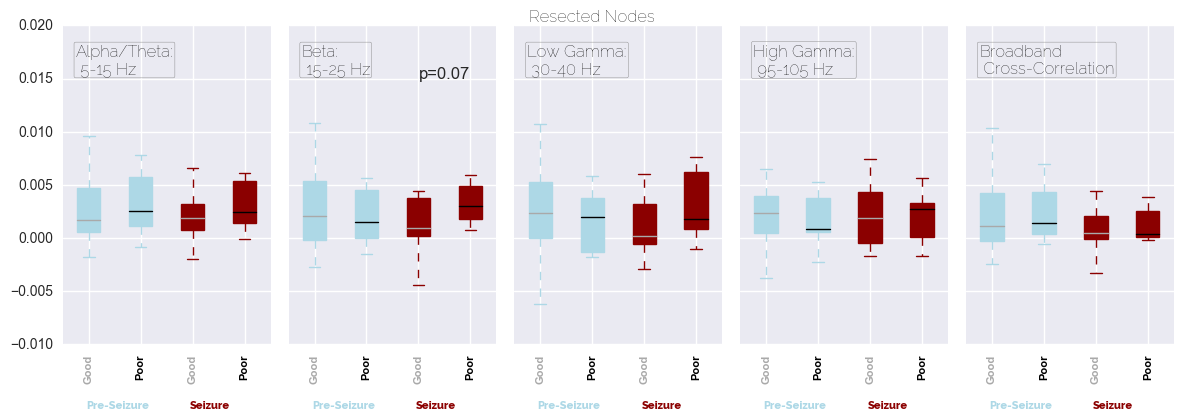

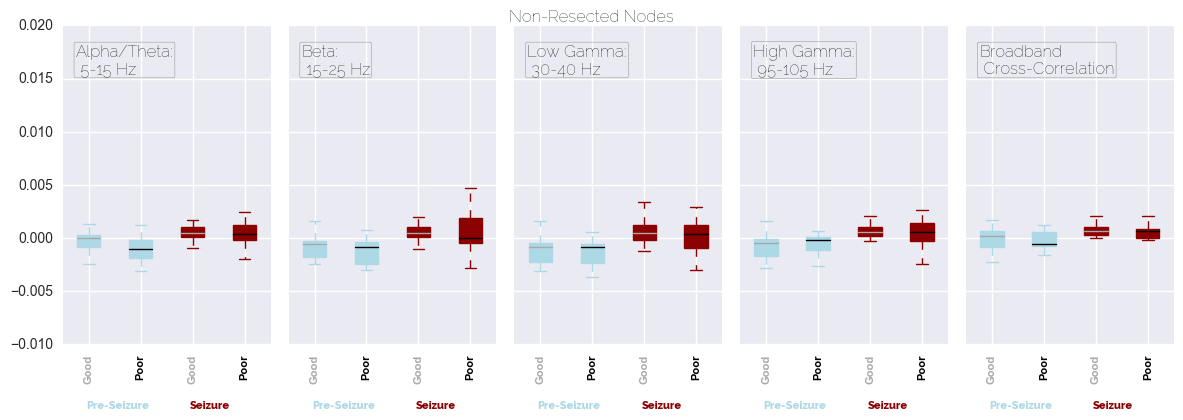

In [27]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.02
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = 0.015

# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,5,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Resected Nodes',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd
    s,pred_p = scipy.stats.ranksums(good_res_minus_nonres[fconn],poor_res_minus_nonres[fconn])    
    print title, 'pred',pred_p
    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
# plt.show()
fig.savefig('%s/../fig/Figure8A.svg'%(comp_dir))


fig,axs = plt.subplots(1,5,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Non-Resected Nodes',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_non_res[fconn],poor_pre_non_res[fconn],good_non_res[fconn],poor_non_res[fconn]])
    draw_plot([good_pre_non_res[fconn],poor_pre_non_res[fconn],good_non_res[fconn],poor_non_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_non_res[fconn], poor_pre_non_res[fconn])
    cd = cohen_d(good_pre_non_res[fconn], poor_pre_non_res[fconn])
    print title, 'pre', s,pre_p,cd
    s,post_p = scipy.stats.ranksums(good_non_res[fconn], poor_non_res[fconn])
    cd = cohen_d(good_non_res[fconn], poor_non_res[fconn])
    print title, 'post',s,post_p,cd
    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title,\
            fontdict={'family':'raleway','size':12,'color':'black'},\
           bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})

plt.tight_layout()
# plt.show()
fig.savefig('%s/../fig/Figure8B.svg'%(comp_dir))

Alpha/Theta:
 5-15 Hz pre 3.06894418627 0.0021481672048 0.0528910554274
Alpha/Theta:
 5-15 Hz post 2.68928098797 0.00716061170808 -0.0716818740211
Beta:
 15-25 Hz pre 3.13222138598 0.0017348900222 0.275700929941
Beta:
 15-25 Hz post 1.20226679462 0.229260177658 -0.534827709391
Low Gamma:
 30-40 Hz pre 3.22713718556 0.0012503549718 0.366397062783
Low Gamma:
 30-40 Hz post 0.0316385998584 0.974760260552 -0.411049451244
High Gamma:
 95-105 Hz pre 3.41696878471 0.000633225397287 0.224276701908
High Gamma:
 95-105 Hz post 1.26554399434 0.205676388053 -0.181782826917
Broadband
 Cross-Correlation pre 1.99323179108 0.0462360714437 0.0519238988729
Broadband
 Cross-Correlation post -0.0949157995752 0.924381706931 -0.176636975898
Alpha/Theta:
 5-15 Hz pre 2.85642796867 0.00428437205926 0.829961117091
Alpha/Theta:
 5-15 Hz post 1.93711781783 0.052730943057 0.392368532389
Beta:
 15-25 Hz pre 2.39677289325 0.016540171856 0.612314450336
Beta:
 15-25 Hz post 2.7907629579 0.00525839670378 1.07447750384

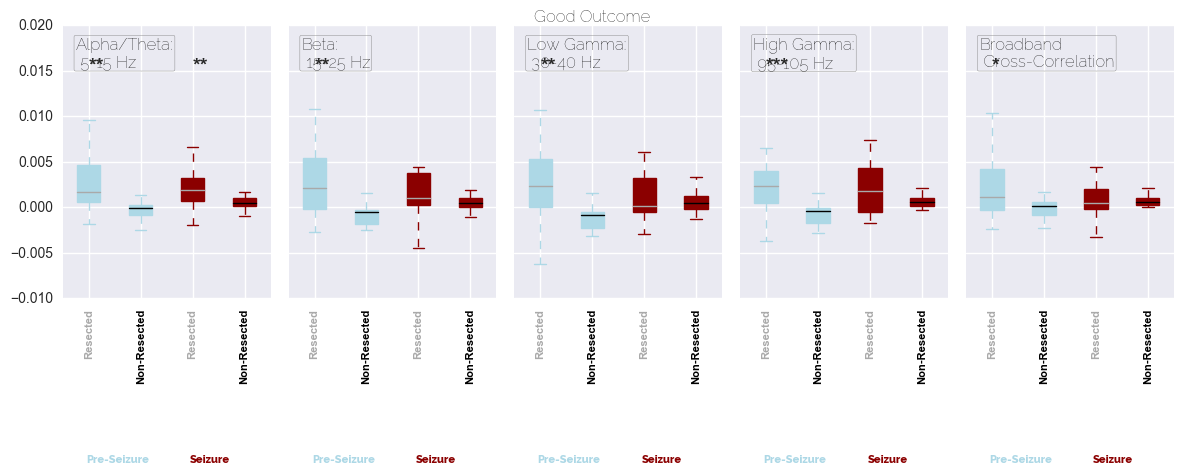

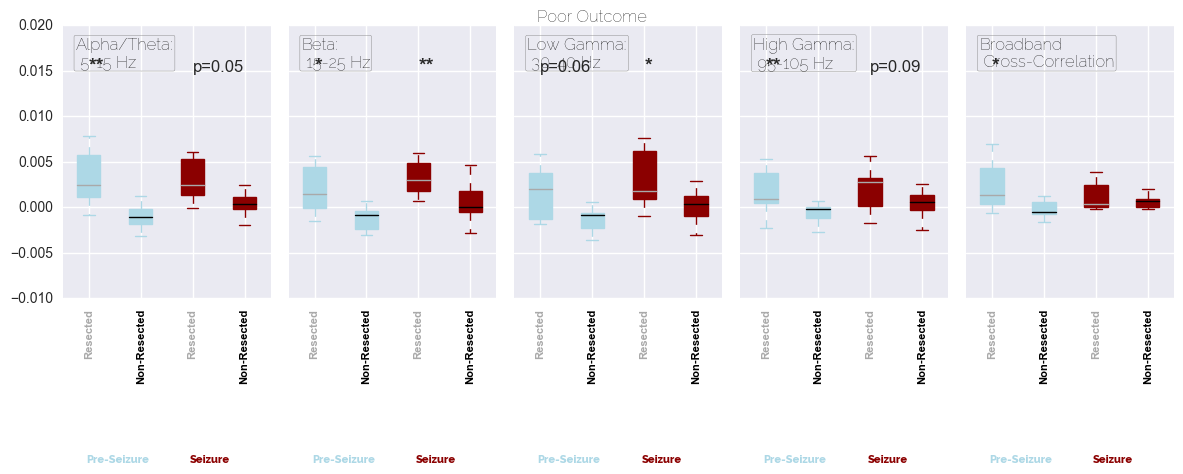

In [28]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.02
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = 0.015
# star_y = 1.5

# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,5,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Good Outcome',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

    draw_plot([good_pre_res[fconn],good_pre_non_res[fconn],good_res[fconn],good_non_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], good_pre_non_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], good_non_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd
    ax.text(0.95,min_y-(max_y-min_y)*0.2*3,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2*3,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Resected','Non-Resected','Resected','Non-Resected'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
# plt.show()
fig.savefig('%s/../fig/Figure8A.svg'%(comp_dir))


fig,axs = plt.subplots(1,5,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Poor Outcome',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

    draw_plot([poor_pre_res[fconn],poor_pre_non_res[fconn],poor_res[fconn],poor_non_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(poor_pre_res[fconn], poor_pre_non_res[fconn])
    cd = cohen_d(poor_pre_res[fconn], poor_pre_non_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(poor_res[fconn], poor_non_res[fconn])
    cd = cohen_d(poor_res[fconn], poor_non_res[fconn])
    print title, 'post',s,post_p, cd
    ax.text(0.95,min_y-(max_y-min_y)*0.2*3,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2*3,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title,\
            fontdict={'family':'raleway','size':12,'color':'black'},\
           bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Resected','Non-Resected','Resected','Non-Resected'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})

plt.tight_layout()
# plt.show()
fig.savefig('%s/../fig/Figure8B.svg'%(comp_dir))

<h1>Figure NULL. Core Comparisons</h1>

In [3]:
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

all_results = {}

for patient_id in PATIENT_IDX:
    # Get outcome
    outcome = data['PATIENTS'][patient_id]['Outcome']
    outcome = get_outcome(outcome)
    resection_type = data['PATIENTS'][patient_id]['Resection Type']
    lesion = data['PATIENTS'][patient_id]['Lesion Status']
    pathology = data['PATIENTS'][patient_id]['Pathology']
    if lesion != 'Non-Lesional' or 'ATL' not in resection_type:
        continue

    # Collect data
    # Initialize boxplot arrays
    pre_res = {}
    pre_non_res = {}
    res = {}
    non_res = {}
    res_minus_nonres = {}

    for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
        # All nodal results
        all_nodal_results = gather_nodal_results(fconn=fconn)
        
        # Get most common subtype
        common_subtype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
        
        try:
            pre_res[fconn]
        except KeyError:
            pre_res[fconn] = []
            pre_non_res[fconn] = []
            res[fconn] = []
            non_res[fconn] = []
            res_minus_nonres[fconn] = []

        _pre_res = []
        _pre_non_res = []
        _res = []
        _non_res = []

        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, channels = get_resected_node_dx(patient_id)
        non_resected_node_idx = []
        for k in range(nodal_control_centrality.shape[0]):
            if k not in resected_node_idx:
                non_resected_node_idx.append(k)

        
        # Load event
        for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():

            event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
            try:
                nodal_control_centrality = all_nodal_results[patient_id][clip_id]
            except KeyError:
                continue
            if data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype'] != common_subtype:
                continue
            print patient_id, clip_id
            nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
            mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#             mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)

            positive_nodes = mean_nodal_control_centrality[resected_node_idx]
            positive_nodes = positive_nodes[positive_nodes>0]
            negative_nodes = mean_nodal_control_centrality[resected_node_idx]
            negative_nodes = negative_nodes[negative_nodes<0]
            ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
#             _pre_res.append(np.nanmean(negative_nodes))
#             _pre_res.append(np.nanmean(positive_nodes))
            _pre_res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(ai)
#                 pre_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
            positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
            positive_nodes = positive_nodes[positive_nodes>0]
            negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
            negative_nodes = negative_nodes[negative_nodes<0]
            ai = (np.abs(np.nanmean(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
#             _pre_non_res.append(np.nanmean(negative_nodes))
#             _pre_non_res.append(np.nanmean(positive_nodes))
            _pre_non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(ai)
#                 pre_non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))

            try:
                nodal_control_centrality = all_nodal_results[patient_id][clip_id]
            except KeyError:
                continue
            
            nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:nodal_control_centrality.shape[1]/4.0*3]
            mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#             mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)

            positive_nodes = mean_nodal_control_centrality[resected_node_idx]
            positive_nodes = positive_nodes[positive_nodes>0]
            negative_nodes = mean_nodal_control_centrality[resected_node_idx]
            negative_nodes = negative_nodes[negative_nodes<0]
            ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
#             _res.append(np.nanmean(negative_nodes))
#             _res.append(np.nanmean(positive_nodes))
            _res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(ai)
#                 res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
            positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
            positive_nodes = positive_nodes[positive_nodes>0]
            negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
            negative_nodes = negative_nodes[negative_nodes<0]
            ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
#             _non_res.append(np.nanmean(negative_nodes))
#             _non_res.append(np.nanmean(positive_nodes))
            _non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(ai)
#                 non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))

        pre_res[fconn].append(np.nanmean(_pre_res))
        pre_non_res[fconn].append(np.nanmean(_pre_non_res))
        res[fconn].append(np.nanmean(_res))
        non_res[fconn].append(np.nanmean(_non_res))
        res_minus_nonres[fconn].append(np.nanmean(_res)-np.nanmean(_non_res))
        
        all_results[patient_id] = {'pre_res':pre_res,'pre_non_res':pre_non_res,'res':res,'non_res':non_res,'res_minus_non_res':res_minus_nonres}


HUP068 1
HUP068 3
HUP068 2
HUP068 4
HUP068 1
HUP068 3
HUP068 2
HUP068 4
HUP068 1
HUP068 3
HUP068 2
HUP068 4
HUP068 1
HUP068 3
HUP068 2
HUP068 4
HUP068 1
HUP068 3
HUP068 2
HUP068 4
HUP068 1
HUP068 3
HUP068 2
HUP068 4
HUP075 5
HUP075 5
HUP075 5
HUP075 5
HUP075 5
HUP075 5
HUP080 1
HUP080 3
HUP080 2
HUP080 4
HUP080 1
HUP080 3
HUP080 2
HUP080 4
HUP080 1
HUP080 3
HUP080 2
HUP080 4
HUP080 1
HUP080 3
HUP080 2
HUP080 4
HUP080 1
HUP080 3
HUP080 2
HUP080 4
HUP080 1
HUP080 3
HUP080 2
HUP080 4
HUP086 1
HUP086 2
HUP086 1
HUP086 2
HUP086 1
HUP086 2
HUP086 1
HUP086 2
HUP086 1
HUP086 2
HUP086 1
HUP086 2
HUP094 1
HUP094 3
HUP094 2
HUP094 1
HUP094 3
HUP094 2
HUP094 1
HUP094 3
HUP094 2
HUP094 1
HUP094 3
HUP094 2
HUP094 1
HUP094 3
HUP094 2
HUP094 1
HUP094 3
HUP094 2
HUP106 3
HUP106 4
HUP106 3
HUP106 4
HUP106 3
HUP106 4
HUP106 3
HUP106 4
HUP106 3
HUP106 4
HUP106 3
HUP106 4
HUP107 3
HUP107 2
HUP107 5
HUP107 4
HUP107 6
HUP107 3
HUP107 2
HUP107 5
HUP107 4
HUP107 6
HUP107 3
HUP107 2
HUP107 5
HUP107 4
HUP107 6
H

In [4]:
all_results

{u'HUP068': {'non_res': {'alphatheta': [0.0011277268120700016],
   'beta': [0.00079723506786860362],
   'broadband_CC': [0.00068615123554682388],
   'highgamma': [0.00062547052085576806],
   'lowgamma': [0.00055390761613912504],
   'veryhigh': [0.00085064379191698391]},
  'pre_non_res': {'alphatheta': [0.00017780815056597508],
   'beta': [-0.00027896193164558868],
   'broadband_CC': [0.00050852609780987427],
   'highgamma': [-0.00108252158788333],
   'lowgamma': [-0.0011249062166355898],
   'veryhigh': [0.00021472163090081742]},
  'pre_res': {'alphatheta': [0.00057768707402283291],
   'beta': [-0.00016891287407147602],
   'broadband_CC': [0.00014373709936280153],
   'highgamma': [0.0019470279809656833],
   'lowgamma': [0.00076278802531434082],
   'veryhigh': [0.0020121885054000112]},
  'res': {'alphatheta': [0.00092675508743361658],
   'beta': [0.0016059458524250519],
   'broadband_CC': [0.0012927343136492392],
   'highgamma': [0.00067440916592237008],
   'lowgamma': [-0.00040953990685

In [5]:
good_pre_res = {}
good_pre_non_res = {}
poor_pre_res = {}
poor_pre_non_res = {}
good_res = {}
good_non_res = {}
poor_res = {}
poor_non_res = {}
good_res_minus_nonres = {}
poor_res_minus_nonres = {}

for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    good_pre_res[fconn] = []
    good_pre_non_res[fconn] = []
    poor_pre_res[fconn] = []
    poor_pre_non_res[fconn] = []
    good_res[fconn] = []
    good_non_res[fconn] = []
    poor_res[fconn] = []
    poor_non_res[fconn] = []
    good_res_minus_nonres[fconn] = []
    poor_res_minus_nonres[fconn] = []

for patient_id in all_results.keys():
    outcome = get_outcome(data['PATIENTS'][patient_id]['Outcome'])
    try:
        for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
            if outcome == 'Good':
                if not np.isnan(all_results[patient_id]['pre_res'][fconn][0]):
                    good_pre_res[fconn].append(all_results[patient_id]['pre_res'][fconn][0])
                if not np.isnan(all_results[patient_id]['pre_non_res'][fconn][0]):
                    good_pre_non_res[fconn].append(all_results[patient_id]['pre_non_res'][fconn][0])
                if not np.isnan(all_results[patient_id]['res'][fconn][0]):
                    good_res[fconn].append(all_results[patient_id]['res'][fconn][0])
                if not np.isnan(all_results[patient_id]['non_res'][fconn][0]):
                    good_non_res[fconn].append(all_results[patient_id]['non_res'][fconn][0])
                if not np.isnan(all_results[patient_id]['res_minus_non_res'][fconn][0]):
                    good_res_minus_nonres[fconn].append(all_results[patient_id]['res_minus_non_res'][fconn][0])
#                 good_pre_res[fconn].append(abs(all_results[patient_id]['pre_res'][fconn][0]))
#                 good_pre_non_res[fconn].append(abs(all_results[patient_id]['pre_non_res'][fconn][0]))
#                 good_res[fconn].append(abs(all_results[patient_id]['res'][fconn][0]))
#                 good_non_res[fconn].append(abs(all_results[patient_id]['non_res'][fconn][0]))
#                 good_res_minus_nonres[fconn].append(abs(all_results[patient_id]['res_minus_non_res'][fconn][0]))
            else:
                if not np.isnan(all_results[patient_id]['pre_res'][fconn][0]):
                    poor_pre_res[fconn].append(all_results[patient_id]['pre_res'][fconn][0])
                if not np.isnan(all_results[patient_id]['pre_non_res'][fconn][0]):
                    poor_pre_non_res[fconn].append(all_results[patient_id]['pre_non_res'][fconn][0])
                if not np.isnan(all_results[patient_id]['res'][fconn][0]):
                    poor_res[fconn].append(all_results[patient_id]['res'][fconn][0])
                if not np.isnan(all_results[patient_id]['non_res'][fconn][0]):
                    poor_non_res[fconn].append(all_results[patient_id]['non_res'][fconn][0])
                if not np.isnan(all_results[patient_id]['res_minus_non_res'][fconn][0]):
                    poor_res_minus_nonres[fconn].append(all_results[patient_id]['res_minus_non_res'][fconn][0])
#                 poor_pre_res[fconn].append(abs(all_results[patient_id]['pre_res'][fconn][0]))
#                 poor_pre_non_res[fconn].append(abs(all_results[patient_id]['pre_non_res'][fconn][0]))
#                 poor_res[fconn].append(abs(all_results[patient_id]['res'][fconn][0]))
#                 poor_non_res[fconn].append(abs(all_results[patient_id]['non_res'][fconn][0]))
#                 poor_res_minus_nonres[fconn].append(abs(all_results[patient_id]['res_minus_non_res'][fconn][0]))
    except TypeError:
        print patient_id, fconn, all_results[patient_id]
    

Alpha/Theta:
 5-15 Hz pre 0.0 1.0 0.492058622355
Alpha/Theta:
 5-15 Hz post -0.188982236505 0.850106739139 0.247849131045
Alpha/Theta:
 5-15 Hz pred 0.570750388058
Beta:
 15-25 Hz pre 1.13389341903 0.256839257958 0.99764032107
Beta:
 15-25 Hz post -0.755928946018 0.449691797969 -0.822399180469
Beta:
 15-25 Hz pred 0.449691797969
Low Gamma:
 30-40 Hz pre 1.51185789204 0.130570018116 1.10078346754
Low Gamma:
 30-40 Hz post -0.755928946018 0.449691797969 -0.707835617092
Low Gamma:
 30-40 Hz pred 0.449691797969
High Gamma:
 95-105 Hz pre 1.13389341903 0.256839257958 0.770363241126
High Gamma:
 95-105 Hz post 0.0 1.0 0.238526732482
High Gamma:
 95-105 Hz pred 1.0
Very High:
 105-256+ Hz pre -0.566946709514 0.570750388058 -0.770543726696
Very High:
 105-256+ Hz post -0.188982236505 0.850106739139 -0.842632342371
Very High:
 105-256+ Hz pred 0.705456986111
Broadband
 Cross-Correlation pre 0.0 1.0 0.313990175456
Broadband
 Cross-Correlation post -0.566946709514 0.570750388058 -0.283502109761
B

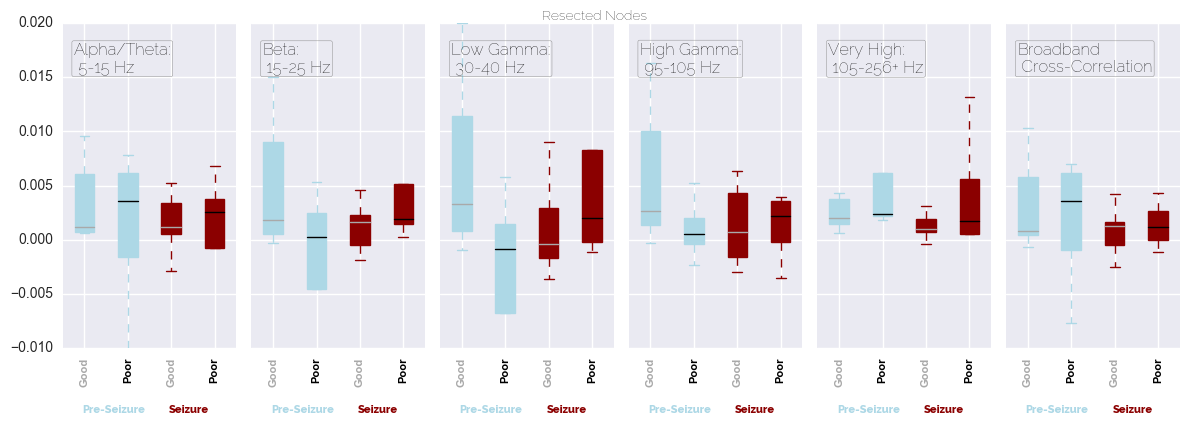

Alpha/Theta:
 5-15 Hz pre 1.51185789204 0.130570018116 1.01115598722
Alpha/Theta:
 5-15 Hz post 0.0 1.0 0.283526649516
Beta:
 15-25 Hz pre 1.13389341903 0.256839257958 0.540507334204
Beta:
 15-25 Hz post -0.755928946018 0.449691797969 -0.540006379006
Low Gamma:
 30-40 Hz pre 0.566946709514 0.570750388058 0.372067595893
Low Gamma:
 30-40 Hz post -1.13389341903 0.256839257958 -0.969595784888
High Gamma:
 95-105 Hz pre -0.377964473009 0.705456986111 -0.28861393303
High Gamma:
 95-105 Hz post -0.188982236505 0.850106739139 -0.281991467367
Very High:
 105-256+ Hz pre 1.13389341903 0.256839257958 0.687208667846
Very High:
 105-256+ Hz post -0.755928946018 0.449691797969 -0.619613895676
Broadband
 Cross-Correlation pre 1.13389341903 0.256839257958 0.789773371774
Broadband
 Cross-Correlation post 0.188982236505 0.850106739139 0.200614099165


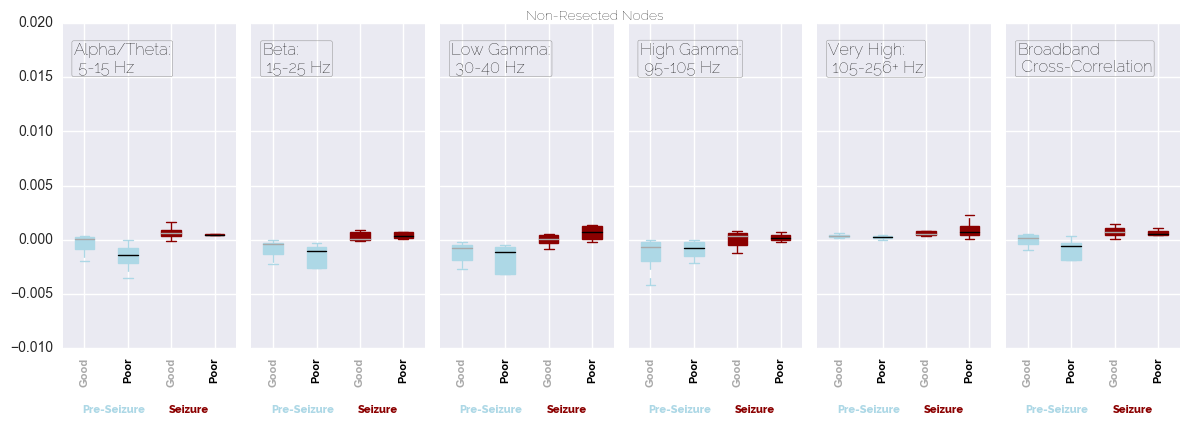

In [6]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.02
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = 0.015

# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Resected Nodes',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd
    s,pred_p = scipy.stats.ranksums(good_res_minus_nonres[fconn],poor_res_minus_nonres[fconn])    
    print title, 'pred',pred_p
    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
plt.show()



fig,axs = plt.subplots(1,6,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Non-Resected Nodes',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_non_res[fconn],poor_pre_non_res[fconn],good_non_res[fconn],poor_non_res[fconn]])
    draw_plot([good_pre_non_res[fconn],poor_pre_non_res[fconn],good_non_res[fconn],poor_non_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_non_res[fconn], poor_pre_non_res[fconn])
    cd = cohen_d(good_pre_non_res[fconn], poor_pre_non_res[fconn])
    print title, 'pre', s,pre_p,cd
    s,post_p = scipy.stats.ranksums(good_non_res[fconn], poor_non_res[fconn])
    cd = cohen_d(good_non_res[fconn], poor_non_res[fconn])
    print title, 'post',s,post_p,cd
    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title,\
            fontdict={'family':'raleway','size':12,'color':'black'},\
           bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})

plt.tight_layout()
plt.show()


<h1>Figure 7B. Change in synchronizability as a feature </h1>

In [1]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = -1
all_features = []
roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                #%DEBUG
#                     print patient_id, clip, avg_data.shape
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.append([clip_iter+1],avg_data)
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                # Update header
                if(clip_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.append(row_data,[0])        
                else:
                    row_data = np.append(row_data,[1])
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                try:
                    all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                except Exception:
                    all_data = row_data
                clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmean(all_data[outcomex==0,width/2:],axis=1)-np.nanmean(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmean(all_data[outcomex==1,width/2:],axis=1)-np.nanmean(all_data[outcomex==1,:width/2],axis=1)
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    roc_results.append((fconn,roc_auc,fpr,tpr))
    
# ax.boxplot(all_features)

# ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
# ax.set_xticklabels(['Good','Poor','Good','Poor','Good','Poor','Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
# ax.set_ylim([-0.35,0.15])
# for ii in range(1,10,2):
#     ax.get_xticklabels()[ii].set_color('black')
# for ii in range(0,10,2):
#     ax.get_xticklabels()[ii].set_color('darkgray')
# ax.text(0.75,-0.3,'Alpha/Theta:\n 5-15 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(2.75,-0.3,'Beta:\n 15-25 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(4.75,-0.3,'Low Gamma:\n 30-40 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(5.25,0.1,'*',fontdict={'size':22,'weight':'bold'})
# ax.text(6.75,-0.3,'High Gamma:\n 95-105 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(8.75,-0.3,'Broadband\n Cross-\nCorrelation',fontdict={'size':10,'weight':'normal'})
# ax.set_ylabel('Change in Resection\n Control Centrality \n(pre-ictal to ictal)',fontdict={'size':14,'weight':'bold'})

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'yellow']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (%0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label='Luck')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.legend(loc="lower right",prop={'size':10,'weight':'bold', 'family':'normal'})

plt.title('Resection Zone\n Control Centrality',fontdict={'size':20})
plt.savefig('../../fig/Figure7B.svg',bbox_inches='tight', format='svg', dpi=1200)

NameError: name 'plt' is not defined

<h1>Figure 5NEW. Node-level control centrality as a feature </h1>

HUP065.Ictal.1.noderes.npz
HUP065.Ictal.3.noderes.npz
HUP065.Ictal.2.noderes.npz
HUP064.Ictal.1.noderes.npz
HUP068.Ictal.1.noderes.npz
HUP068.Ictal.3.noderes.npz
HUP068.Ictal.2.noderes.npz
HUP068.Ictal.5.noderes.npz
HUP068.Ictal.4.noderes.npz
HUP070.Ictal.1.noderes.npz
HUP070.Ictal.2.noderes.npz
HUP070.Ictal.5.noderes.npz
HUP070.Ictal.4.noderes.npz
HUP070.Ictal.7.noderes.npz
HUP070.Ictal.6.noderes.npz
HUP070.Ictal.8.noderes.npz
HUP073.Ictal.1.noderes.npz
HUP073.Ictal.3.noderes.npz
HUP073.Ictal.2.noderes.npz
HUP073.Ictal.5.noderes.npz
HUP073.Ictal.4.noderes.npz
HUP074.Ictal.3.noderes.npz
HUP074.Ictal.2.noderes.npz
HUP074.Ictal.4.noderes.npz
HUP074.Ictal.7.noderes.npz
HUP074.Ictal.6.noderes.npz
HUP075.Ictal.5.noderes.npz
HUP078.Ictal.1.noderes.npz
HUP078.Ictal.3.noderes.npz
HUP078.Ictal.2.noderes.npz
HUP078.Ictal.5.noderes.npz
HUP078.Ictal.4.noderes.npz
HUP080.Ictal.1.noderes.npz
HUP080.Ictal.3.noderes.npz
HUP080.Ictal.2.noderes.npz
HUP080.Ictal.4.noderes.npz
HUP082.Ictal.1.noderes.npz
H

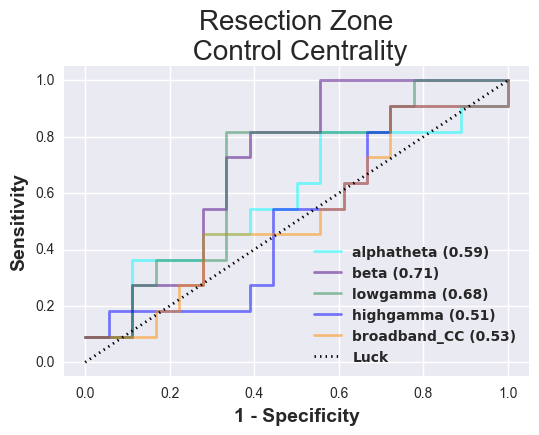

In [43]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    feature_vector = []
    outcomex = []

    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)

    for patient_id in PATIENT_IDX:
        # Get outcome
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        pre_res = []
        pre_non_res = []
        res = []
        non_res = []
        
        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, channels = get_resected_node_dx(patient_id)
        non_resected_node_idx = []
        for k in range(nodal_control_centrality.shape[0]):
            if k not in resected_node_idx:
                non_resected_node_idx.append(k)

        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(ai)
#                 pre_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmean(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(ai)
#                 pre_non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(ai)
#                 res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(ai)
#                 non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))

            feature_vector.append(np.nanmean(res))
            outcomex.append(0)
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
#                 print patient_id, clip_id
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)

                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(ai)
#                 pre_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 pre_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                pre_non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(ai)
#                 pre_non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 pre_non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue
                
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(ai)
#                 res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[resected_node_idx]))
#                 res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                positive_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes<0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                non_res.append(np.nanmean(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(ai)
#                 non_res.append(scipy.stats.kurtosis(mean_nodal_control_centrality[non_resected_node_idx]))
#                 non_res.append(cohen_d(mean_nodal_control_centrality[resected_node_idx],mean_nodal_control_centrality[non_resected_node_idx]))
                
            feature_vector.append(np.nanmean(res))
            outcomex.append(1)
            
    feature_vector = np.array(feature_vector)
    outcomex = np.array(outcomex)
    s,p = scipy.stats.ranksums(feature_vector[outcomex==0], feature_vector[outcomex==1])
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,feature_vector)    
    roc_auc = auc(fpr,tpr)
    roc_results.append((fconn,roc_auc,fpr,tpr))
    
# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'yellow']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (%0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label='Luck')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.legend(loc="lower right",prop={'size':10,'weight':'bold', 'family':'normal'})

plt.title('Resection Zone\n Control Centrality',fontdict={'size':20})
plt.show()

In [38]:
tmp = feature_vector
tmp[np.isnan(feature_vector)] = []
print tmp

ValueError: NumPy boolean array indexing assignment cannot assign 0 input values to the 2 output values where the mask is true

<h1>Figure 5NEW Part A: Time Varying </h1>

0.8758 0.0 0.590909090909


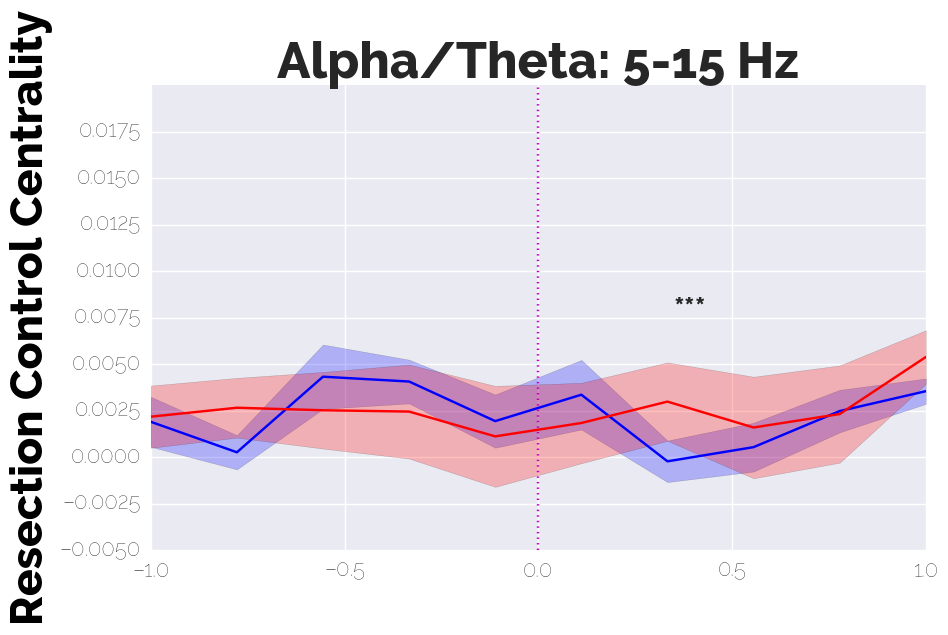

0.8765 0.0 0.484848484848


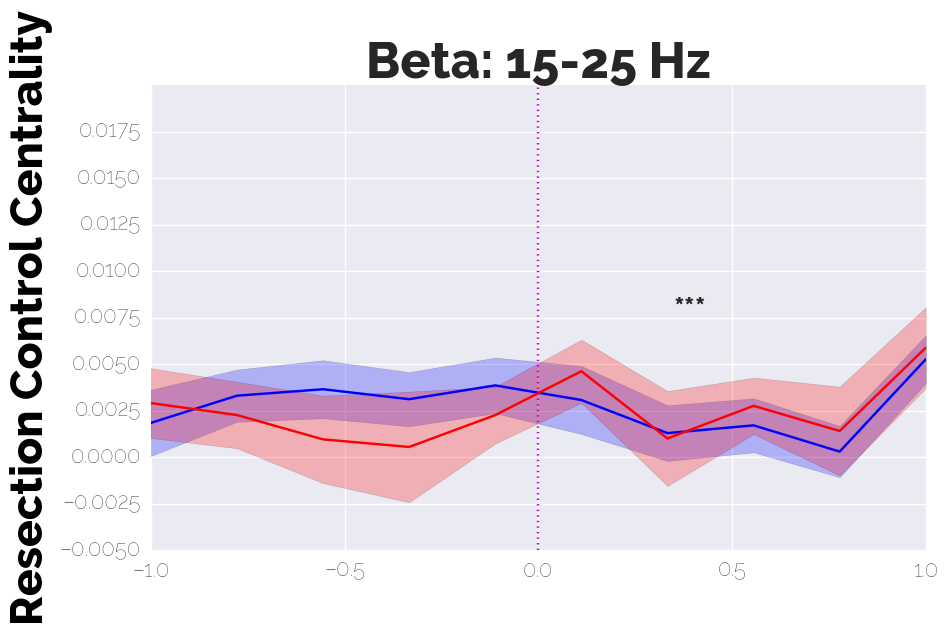

0.8473 0.0 0.646464646465


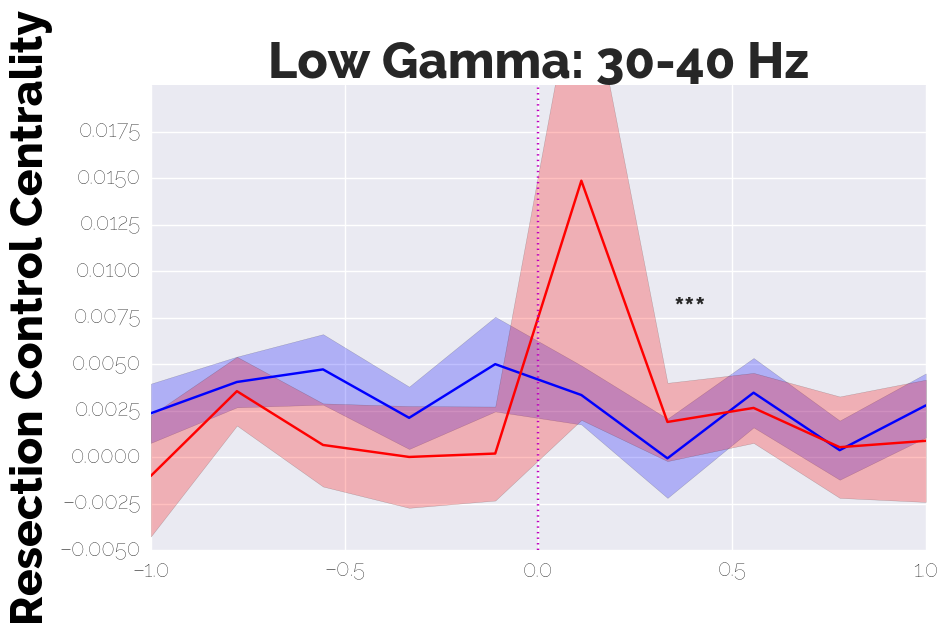

0.5468 0.0 0.510101010101


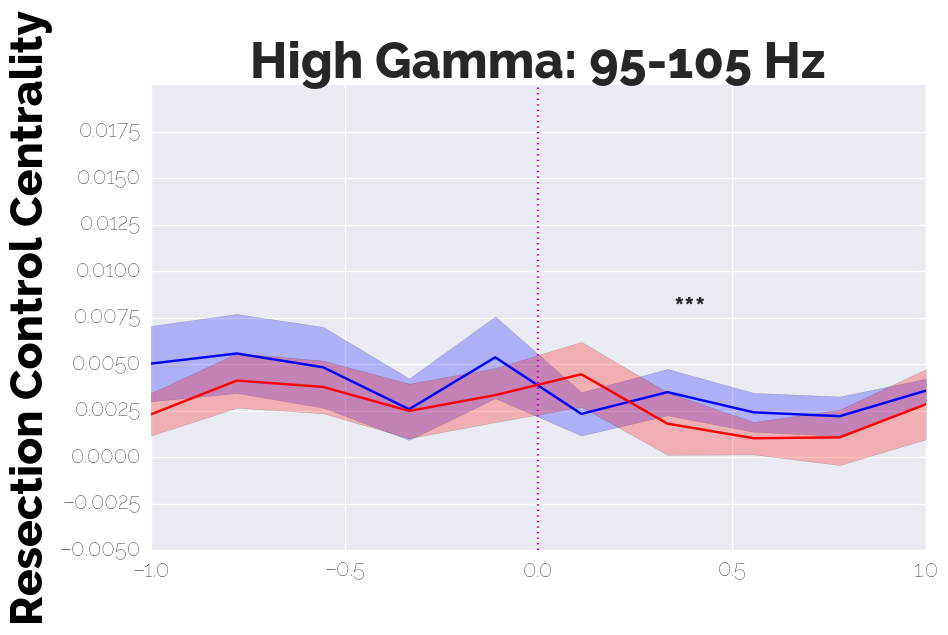

0.0611 0.0 0.565656565657


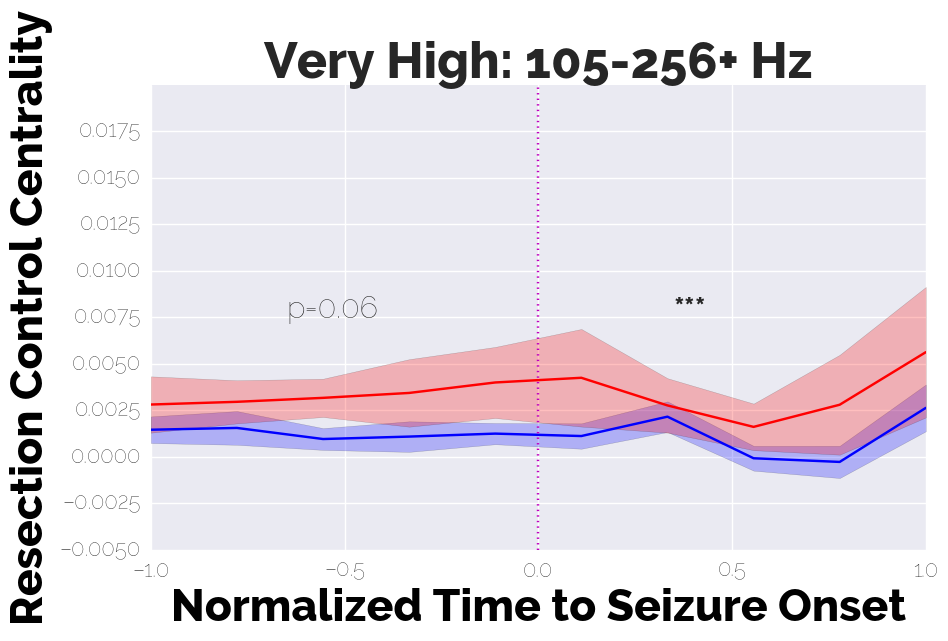

0.9559 0.0 0.5


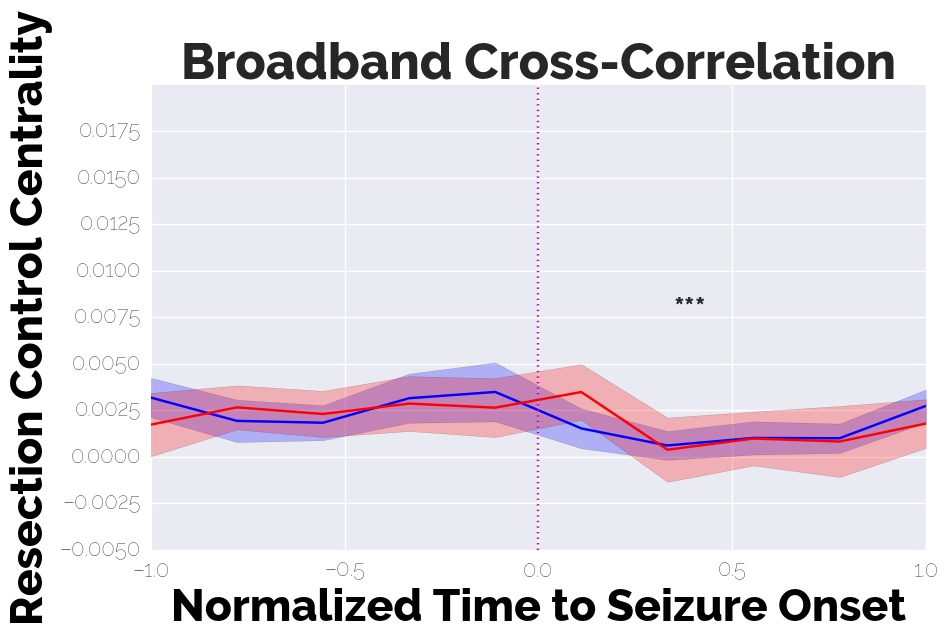

In [30]:
width = 14

# xlim_low = -0.01
# xlim_high = 0.03
ylim_low = -0.005
ylim_high = 0.02
star_y = 0.0075
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_nodal_results = gather_nodal_results(fconn=fconn)    
    
    if width == -1:
        width = 1E100
        for pt, clips in all_nodal_results.items():
            for event_id, clip in clips.items():                
                if clip.shape[1] < width:
                    width = clip.shape[1]
    width = 10
    for pt, clips in all_nodal_results.items():
        for event_id, clip in clips.items():            
            xp = np.linspace(-1.0,1.0,clip.shape[1])
            f = scipy.interpolate.interp1d(xp,clip)
            noderes_norm = f(np.linspace(-1.0,1.0,width))
            all_nodal_results[pt][event_id] = noderes_norm
    
    num_fts = width
    pt_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_nodal_results[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            
            # Get resected nodes and non-resected nodes
            first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
            nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
            resected_node_idx, channels = get_resected_node_dx(patient_id)
            non_resected_node_idx = []
            for k in range(nodal_control_centrality.shape[0]):
                if k not in resected_node_idx:
                    non_resected_node_idx.append(k)
                
            for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']

                avg_data = np.array(())                    
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = np.nanmean(clip_data[resected_node_idx,:],axis=0)
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
#                 print pid, avg_data.shape
                avg_data = np.nanmean(avg_data,axis=1)
                

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            if(row_data.shape[0] != num_fts+2):
                continue
            ft_matrix.append(row_data)
            pt_iter += 1
    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)

    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 36
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    matplotlib.rcParams['axes.labelsize'] = 32
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'

    
    plt.figure(dpi=1200,figsize=(10,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmean(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmean(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmean(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmean(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmean(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmean(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((ylim_low, ylim_high))
    plt.plot([0,0],[ylim_low, ylim_high],color='m',linestyle=':')
    plt.yticks(np.arange(ylim_low, ylim_high,(ylim_high-ylim_low)/10.0))
    plt.title(title)
    if fconn == 'broadband_CC' or fconn == 'veryhigh':
        plt.xlabel('Normalized Time to Seizure Onset')    
    plt.ylabel('Resection Control Centrality')
    plt.grid(True)
    
    # Make significance indicators
#     fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:width/4.0*3.0],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
#     fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:width/4.0*3.0],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
#     fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:width/4.0*3.0],axis=1))
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:width/4.0*3.0],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        plt.text(-0.65,star_y, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        plt.text(-0.65,star_y, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        plt.text(-0.65,star_y, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        plt.text(-0.65,star_y, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        plt.text(0.35,star_y, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        plt.text(0.35,star_y, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        plt.text(0.35,star_y, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        plt.text(0.35,star_y, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})
#     plt.savefig('../../fig/Figure6B_%s.svg'%fconn,bbox_inches='tight', format='svg', dpi=1200)
    print pre_p, post_p, roc_auc
    plt.show()


In [47]:
all_nodal_results['HUP064']['1'].shape

(86, 214)

<h1>Figure S10. Distribution of mean node-level control centrality </h1>

In [2]:
run_stereotype_only = False
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

# Collect data
# Initialize boxplot arrays
good_pre_res = {}
good_res = {}
poor_pre_res = {}
poor_res = {}

for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)
    
    
    try:
        good_pre_res[fconn]        
    except KeyError:
        good_pre_res[fconn] = []
        good_res[fconn] = []
        poor_pre_res[fconn] = []
        poor_res[fconn] = []
    for patient_id in sorted(PATIENT_IDX):
        if len(data['PATIENTS'][patient_id]['ELECTRODE_LABELS'].split('/')[-1].split('_')) <= 3:
            continue
        if patient_id == 'HUP111A':
            continue
        # Get outcome
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        pre_res = []
        res = []
        
        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, non_resected_node_idx, channels = get_resected_node_dx(patient_id)

        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if clip_id == '1000':
                    continue
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
                
                pre_res.append(np.nanmedian(mean_nodal_control_centrality[resected_node_idx]))
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
                
                res.append(np.nanmedian(mean_nodal_control_centrality[resected_node_idx]))


            good_pre_res[fconn].append(np.nanmedian(pre_res))
            good_res[fconn].append(np.nanmedian(res))
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if clip_id == '1000':
                    continue
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 print patient_id, clip_id
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)

                pre_res.append(np.nanmedian(mean_nodal_control_centrality[resected_node_idx]))

                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue
                
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
                
                res.append(np.nanmedian(mean_nodal_control_centrality[resected_node_idx]))
                
            poor_pre_res[fconn].append(np.nanmedian(pre_res))
            poor_res[fconn].append(np.nanmedian(res))
            

Alpha/Theta:
 5-15 Hz pre -0.0705605699059 0.943747492813 0.299666928263
Alpha/Theta:
 5-15 Hz post -0.446883609404 0.654959098972 0.161572176967
Beta:
 15-25 Hz pre -0.211681709718 0.83235535828 0.372019375296
Beta:
 15-25 Hz post -0.258722089655 0.79584967464 0.126715575059
Low Gamma:
 30-40 Hz pre 0.588004749216 0.556529105076 0.439460841337
Low Gamma:
 30-40 Hz post -0.68208550909 0.495184882988 0.234443716245
High Gamma:
 95-105 Hz pre 0.35280284953 0.72423624736 0.23960986443
High Gamma:
 95-105 Hz post -0.446883609404 0.654959098972 0.29595354845
Very High:
 105-256+ Hz pre -1.9521757674 0.0509173401654 -0.809201840915
Very High:
 105-256+ Hz post -0.68208550909 0.495184882988 -0.295919811571
Broadband
 Cross-Correlation pre 0.0235201899686 0.981235333673 0.183618054842
Broadband
 Cross-Correlation post -0.305762469592 0.759785505665 0.140007640095


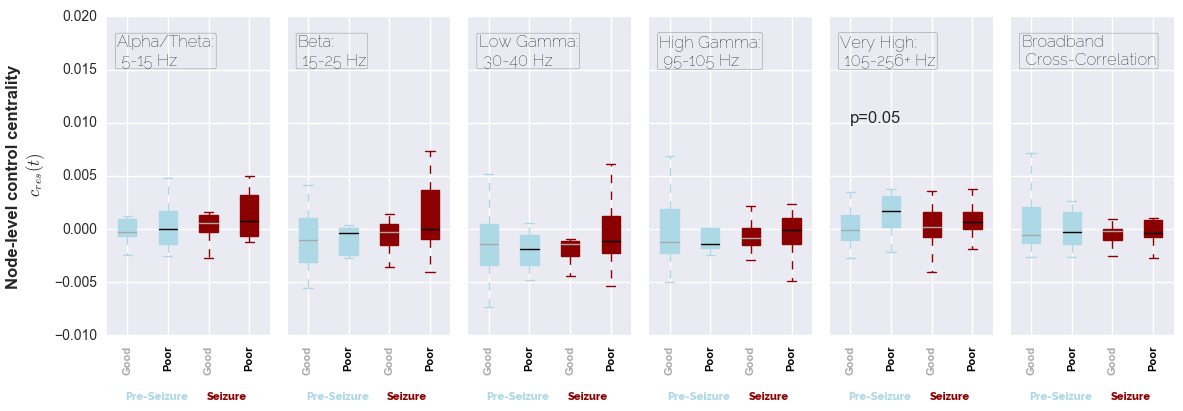

In [3]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'darkblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.02
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = 0.01


# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
# fig.set_figwidth(2.75591)
fig.set_size_inches((12,4))
# fig.suptitle('Resection ',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level control centrality\n $c_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['darkblue','darkblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd

    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
# plt.show()
if run_stereotype_only:
#     blah
    fig.savefig('%s/../fig/FigureS_mean_stero.png'%(comp_dir))
else:
    fig.savefig('%s/../fig/FigureS10.png'%(comp_dir))



Beta:
 15-25 Hz pre -0.211681709718 0.83235535828 0.372019375296
Beta:
 15-25 Hz post -0.258722089655 0.79584967464 0.126715575059
Very High:
 105-256+ Hz pre -1.9521757674 0.0509173401654 -0.809201840915
Very High:
 105-256+ Hz post -0.68208550909 0.495184882988 -0.295919811571
Very High:
 105-256+ Hz pre -1.9521757674 0.0509173401654 -0.809201840915
Very High:
 105-256+ Hz post -0.68208550909 0.495184882988 -0.295919811571
Very High:
 105-256+ Hz pre -1.9521757674 0.0509173401654 -0.809201840915
Very High:
 105-256+ Hz post -0.68208550909 0.495184882988 -0.295919811571
Very High:
 105-256+ Hz pre -1.9521757674 0.0509173401654 -0.809201840915
Very High:
 105-256+ Hz post -0.68208550909 0.495184882988 -0.295919811571
Very High:
 105-256+ Hz pre -1.9521757674 0.0509173401654 -0.809201840915
Very High:
 105-256+ Hz post -0.68208550909 0.495184882988 -0.295919811571


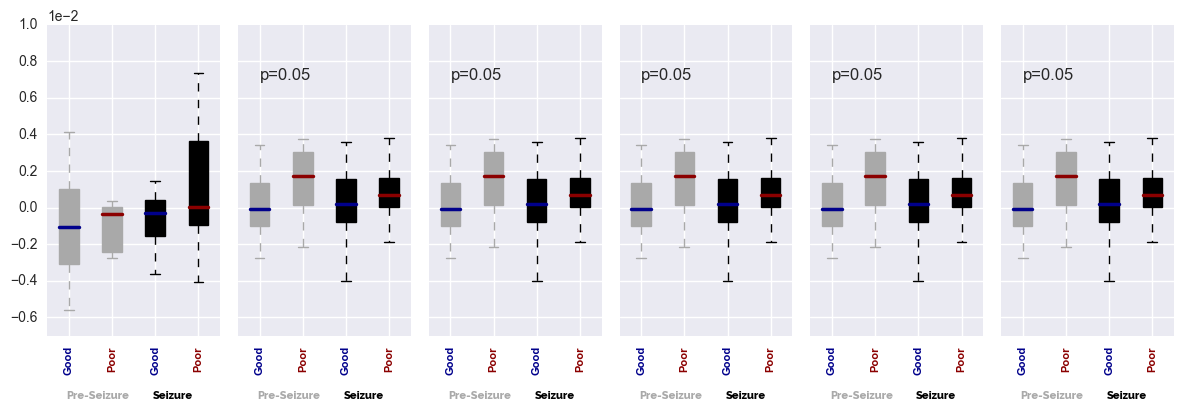

In [9]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'darkgray',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'black',
        'weight':'bold',
        'size':8,
        }

max_y = 0.01
# max_y = 3.0
min_y = -0.007
# min_y = -3.0
star_y = 0.007


# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    medianprops = dict(linestyle='-', linewidth=2.5)
    bp = ax.boxplot(data, patch_artist=True,medianprops=medianprops)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
# fig.set_figwidth(2.75591)
fig.set_size_inches((12,4))
# fig.suptitle('Resection ',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['beta','veryhigh','veryhigh','veryhigh','veryhigh','veryhigh']):
    
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level control centrality\n $c_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['darkgray','darkgray','black','black'],
              [('/','darkblue'),('/','darkred'),('/','darkblue'),('/','darkred')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd

    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
#     ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
#             fontdict={'family':'raleway','size':12,'color':'black'}, \
#             bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('darkred')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkblue')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,3),useMathText=True,useOffset=False)
plt.tight_layout()
plt.show()


<h1> Figure S11/S19. Node-level control centrality of Time-Varying Functional Network </h1>

In [3]:
run_stereotype_only = False
width = 10
all_freq_nodal_results = {}
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    all_freq_nodal_results[fconn] = gather_resection_norm_nodal_results(fconn=fconn,width=width)

0.8935 0.0 0.465240641711
0.8152 0.0 0.631016042781
0.6789 0.0 0.668449197861
0.3581 0.0 0.347593582888
0.1479 0.0 0.395721925134
0.8559 0.0 0.491978609626


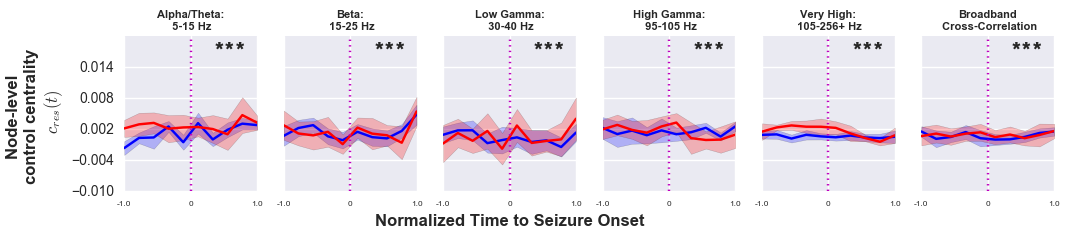

In [4]:
width = 10

# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.02
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = 0.015

fig,axs = plt.subplots(1,6,sharey=True, sharex=True)
fig.set_size_inches((12,2))

for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
#     all_nodal_results = gather_resection_norm_nodal_results(fconn=fconn,width=width)
    all_nodal_results = all_freq_nodal_results[fconn]
    num_fts = width

    pt_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
        if patient_id == 'HUP111A':
            continue
        if(skip_chop and 'CHOP' in patient_id):
            continue
        if(skip_mayo and 'Study' in patient_id):
            continue
        if(skip_hup and 'HUP' in patient_id):
            continue

        index_col.append(patient_id)
        row_data = np.array((pt_iter+1,))    
        for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):                    
            if(pid != patient_id):
                continue
            outcome = data['PATIENTS'][patient_id]['Outcome']

            avg_data = np.array(())                    
            for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                if clip == '1000':
                    continue
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
                res = clip_data                        
                if(res.shape[0] == num_fts+1):
                    res = res[:num_fts]
                try:                
                    avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                except Exception:                
                    avg_data = np.reshape(res,(num_fts,1))                    
            avg_data = np.nanmedian(avg_data,axis=1)

            # Update row_data
            row_data = np.hstack((row_data,avg_data)) 

            # Update header
            if(pt_iter == 0):
                for t in range(1,num_fts+1):
                    out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
        if(get_outcome(outcome) == 'Good'):        
            row_data = np.hstack((row_data,[0]))        
        else:
            row_data = np.hstack((row_data,[1]))
        if(row_data.shape[0] != num_fts+2):
            continue
        ft_matrix.append(row_data)
        pt_iter += 1
    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')

    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')

    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 36
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    matplotlib.rcParams['axes.labelsize'] = 32
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'

    
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level \ncontrol centrality \n $c_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
        ax.set_xlabel('Normalized Time to Seizure Onset',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'
    
    ax.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    ax.hold(True)
    ax.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    ax.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    ax.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    ax.set_xlim(( -1.0, 1.0))    
    ax.set_ylim((min_y, max_y))
    ax.plot([0,0],[min_y,max_y],color='m',linestyle=':')
    ax.set_yticks(np.arange(min_y,max_y,(max_y-min_y)/5.0))
    
    ax.set_xticks([-1.0,0,1.0])
    ax.set_xticklabels([-1.0,0,1.0],fontdict={'size':6,'weight':'normal'})

    ax.set_title(title,fontdict={'size':8,'weight':'bold'})    
    
    ax.grid(True)
    
    # Make significance indicators

    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        ax.text(-0.65,star_y, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        ax.text(-0.65,star_y, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        ax.text(-0.65,star_y, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        ax.text(-0.65,star_y, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        ax.text(0.35,star_y, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        ax.text(0.35,star_y, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        ax.text(0.35,star_y, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        ax.text(0.35,star_y, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})

    print pre_p, post_p, roc_auc

if run_stereotype_only:
#     blah
    plt.savefig('../../fig/FigureS19.png',bbox_inches='tight', format='png', dpi=1200)
else:
    plt.savefig('../../fig/FigureS11.png',bbox_inches='tight', format='png', dpi=1200)
# plt.show()

0.6832 0.0 0.668449197861


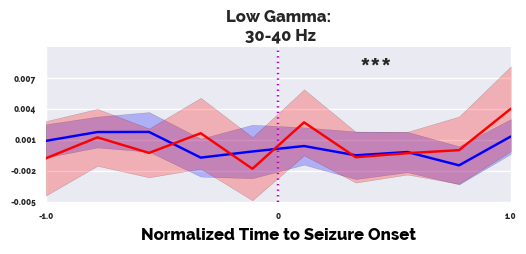

In [26]:
width = 10

# # Figure font options
# font1 = {'family':'raleway',
#         'color': 'lightblue',
#         'weight':'bold',
#         'size':8,
#         }
# font2 = {'family':'raleway',
#         'color': 'darkred',
#         'weight':'bold',
#         'size':8,
#         }

max_y = 0.01
# max_y = 3.0
min_y = -0.005
# min_y = -3.0
star_y = 0.007

fig = plt.figure(figsize=(6,2))
axs = plt.gca()


for ax, fconn in zip([axs],['lowgamma']):

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
#     all_nodal_results = gather_resection_norm_nodal_results(fconn=fconn,width=width)
    all_nodal_results = all_freq_nodal_results[fconn]
    num_fts = width

    pt_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
        if patient_id == 'HUP111A':
            continue
        if(skip_chop and 'CHOP' in patient_id):
            continue
        if(skip_mayo and 'Study' in patient_id):
            continue
        if(skip_hup and 'HUP' in patient_id):
            continue

        index_col.append(patient_id)
        row_data = np.array((pt_iter+1,))    
        for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):                    
            if(pid != patient_id):
                continue
            outcome = data['PATIENTS'][patient_id]['Outcome']

            avg_data = np.array(())                    
            for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                if clip == '1000':
                    continue
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
                res = clip_data                        
                if(res.shape[0] == num_fts+1):
                    res = res[:num_fts]
                try:                
                    avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                except Exception:                
                    avg_data = np.reshape(res,(num_fts,1))                    
            avg_data = np.nanmedian(avg_data,axis=1)

            # Update row_data
            row_data = np.hstack((row_data,avg_data)) 

            # Update header
            if(pt_iter == 0):
                for t in range(1,num_fts+1):
                    out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
        if(get_outcome(outcome) == 'Good'):        
            row_data = np.hstack((row_data,[0]))        
        else:
            row_data = np.hstack((row_data,[1]))
        if(row_data.shape[0] != num_fts+2):
            continue
        ft_matrix.append(row_data)
        pt_iter += 1
    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')

    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')

#     font = {'family' : 'Raleway',
#         'weight' : 'normal',
#         'size'   : 32}
#     matplotlib.rc('font', **font)
#     matplotlib.rcParams['axes.titlesize'] = 36
#     matplotlib.rcParams['axes.titleweight'] = 'bold'
#     matplotlib.rcParams['axes.labelsize'] = 32
#     matplotlib.rcParams['axes.labelweight'] = 'bold'
#     matplotlib.rcParams['ytick.labelsize'] = 16
#     matplotlib.rcParams['xtick.labelsize'] = 16
#     matplotlib.rcParams['axes.labelcolor'] = 'black'

    
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level \ncontrol centrality \n $c_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
        ax.set_xlabel('Normalized Time to Seizure Onset',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'
    
    ax.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    ax.hold(True)
    ax.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    ax.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    ax.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    ax.set_xlim(( -1.0, 1.0))    
    ax.set_ylim((min_y, max_y))
    ax.plot([0,0],[min_y,max_y],color='m',linestyle=':')
    ax.set_yticks(np.arange(min_y,max_y,(max_y-min_y)/5.0))
    ax.set_yticklabels(np.arange(min_y,max_y,(max_y-min_y)/5.0),fontdict={'size':6,'weight':'bold'})

    ax.set_xticks([-1.0,0,1.0])
    ax.set_xticklabels([-1.0,0,1.0],fontdict={'size':6,'weight':'bold'})

    ax.set_title(title,fontdict={'size':12,'weight':'bold'})    
    
    ax.grid(True)
    
    # Make significance indicators

    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        ax.text(-0.65,star_y, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        ax.text(-0.65,star_y, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        ax.text(-0.65,star_y, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        ax.text(-0.65,star_y, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        ax.text(0.35,star_y, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        ax.text(0.35,star_y, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        ax.text(0.35,star_y, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        ax.text(0.35,star_y, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})

    print pre_p, post_p, roc_auc


plt.show()

<h1>Figure S12/S20. ROC Curve of using change in mean node-level control centrality in the resection zone </h1>

In [2]:
run_stereotype_only = False
width = 10
all_freq_nodal_results = {}
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    all_freq_nodal_results[fconn] = gather_resection_norm_nodal_results(fconn=fconn,width=width)

alphatheta 0.305762469592 0.759785505665
0.534759358289
beta -1.15248930846 0.249120060672
0.631016042781
lowgamma -1.48177196802 0.138400980263
0.668449197861
highgamma 1.34065082821 0.18003384635
0.652406417112
veryhigh 0.917287408777 0.358992053592
0.604278074866
broadband_CC 0.0705605699059 0.943747492813
0.508021390374
alphatheta 0.534759358289
beta 0.631016042781
lowgamma 0.668449197861
highgamma 0.652406417112
veryhigh 0.604278074866
broadband_CC 0.508021390374


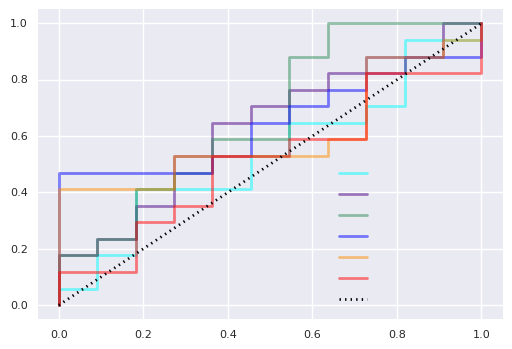

In [4]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = 10
all_features = []
roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_nodal_results = all_freq_nodal_results[fconn]
    width = len(map(lambda x: x.values(), all_nodal_results.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_nodal_results.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if patient_id == 'HUP111A':
                continue
#             print patient_id
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    if clip == '1000':
                        continue
                    if run_stereotype_only:
                        common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != common_stype:
                            continue
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                #%DEBUG
#                     print patient_id, clip, avg_data.shape
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.append([clip_iter+1],avg_data)
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                # Update header
                if(clip_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.append(row_data,[0])        
                else:
                    row_data = np.append(row_data,[1])
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                try:
                    all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                except Exception:
                    all_data = row_data
                clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmedian(all_data[outcomex==0,width/2:],axis=1)-np.nanmedian(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmedian(all_data[outcomex==1,width/2:],axis=1)-np.nanmedian(all_data[outcomex==1,:width/2],axis=1)
    
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
    if run_stereotype_only:
        tpr = np.loadtxt('FigureS20_%s_sensitivity.csv'%fconn)
        fpr = np.loadtxt('FigureS20_%s_specificity.csv'%fconn)
        fpr = 1-fpr
    else:
        tpr = np.loadtxt('FigureS12_%s_sensitivity.csv'%fconn)
        fpr = np.loadtxt('FigureS12_%s_specificity.csv'%fconn)
        fpr = 1-fpr
    roc_auc = auc(fpr,tpr)
    print roc_auc
    
    roc_results.append((fconn,roc_auc,fpr,tpr))
    if run_stereotype_only:
        np.savetxt('FigureS20_%s_outcomex.csv'%fconn,outcomex)
        np.savetxt('FigureS20_%s_threshold.csv'%fconn,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))
    else:
        np.savetxt('FigureS12_%s_outcomex.csv'%fconn,outcomex)
        np.savetxt('FigureS12_%s_threshold.csv'%fconn,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'red']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
#     ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (%0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '                       ', alpha=0.5)
    print fconn, roc_auc
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label=' ')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

# ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
# ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.set_xticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.set_yticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.legend(loc="lower right",prop={'size':10,'weight':'bold', 'family':'normal'})
# plt.show()
# plt.title('Node-level control centrality',fontdict={'size':20})
if run_stereotype_only:
    plt.savefig('../../fig/FigureS20.png',bbox_inches='tight', format='png', dpi=1200)
else:
    plt.savefig('../../fig/FigureS12.png',bbox_inches='tight', format='png', dpi=1200)

highgamma 1.85809500752 0.0631555236903
0.711229946524
highgamma 0.711229946524


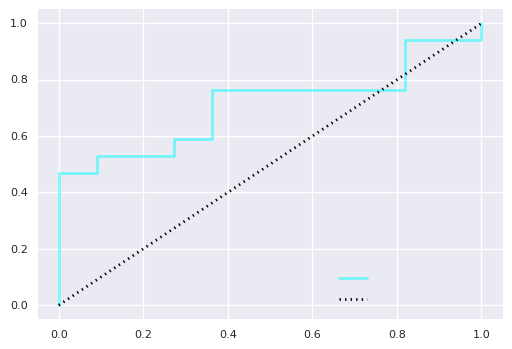

In [38]:
#### HACK TO GET FIGURE FOR PRESENTAITON
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = 10
all_features = []
roc_results = []
for fconn in ['highgamma']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_nodal_results = all_freq_nodal_results[fconn]
    width = len(map(lambda x: x.values(), all_nodal_results.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_nodal_results.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if patient_id == 'HUP111A':
                continue
#             print patient_id
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    if clip == '1000':
                        continue
                    if run_stereotype_only:
                        common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != common_stype:
                            continue
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                #%DEBUG
#                     print patient_id, clip, avg_data.shape
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.append([clip_iter+1],avg_data)
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                # Update header
                if(clip_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.append(row_data,[0])        
                else:
                    row_data = np.append(row_data,[1])
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                try:
                    all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                except Exception:
                    all_data = row_data
                clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmedian(all_data[outcomex==0,width/2:],axis=1)-np.nanmedian(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmedian(all_data[outcomex==1,width/2:],axis=1)-np.nanmedian(all_data[outcomex==1,:width/2],axis=1)
    
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
    if run_stereotype_only:
        tpr = np.loadtxt('FigureS20_%s_sensitivity.csv'%fconn)
        fpr = np.loadtxt('FigureS20_%s_specificity.csv'%fconn)
        fpr = 1-fpr
    else:
        tpr = np.loadtxt('FigureS12_%s_sensitivity.csv'%fconn)
        fpr = np.loadtxt('FigureS12_%s_specificity.csv'%fconn)
        fpr = 1-fpr
    roc_auc = auc(fpr,tpr)
    print roc_auc
    
    roc_results.append((fconn,roc_auc,fpr,tpr))
    if run_stereotype_only:
        np.savetxt('FigureS20_%s_outcomex.csv'%fconn,outcomex)
        np.savetxt('FigureS20_%s_threshold.csv'%fconn,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))
    else:
        np.savetxt('FigureS12_%s_outcomex.csv'%fconn,outcomex)
        np.savetxt('FigureS12_%s_threshold.csv'%fconn,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'red']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
#     ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (%0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '                       ', alpha=0.5)
    print fconn, roc_auc
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label=' ')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

# ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
# ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.set_xticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.set_yticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.legend(loc="lower right",prop={'size':10,'weight':'bold', 'family':'normal'})
plt.show()
# plt.title('Node-level control centrality',fontdict={'size':20})
# if run_stereotype_only:
#     plt.savefig('../../fig/FigureS20.png',bbox_inches='tight', format='png', dpi=1200)
# else:
#     plt.savefig('../../fig/FigureS12.png',bbox_inches='tight', format='png', dpi=1200)

alphatheta -1.34065082821 0.18003384635
0.652406417112
beta 0.0235201899686 0.981235333673
0.502673796791
lowgamma 0.446883609404 0.654959098972
0.449197860963
highgamma -0.16464132978 0.869226298639
0.51871657754
veryhigh -1.71697386771 0.0859839468186
0.695187165775
broadband_CC -0.258722089655 0.79584967464
0.529411764706
alphatheta 0.652406417112
beta 0.502673796791
lowgamma 0.449197860963
highgamma 0.51871657754
veryhigh 0.695187165775
broadband_CC 0.529411764706


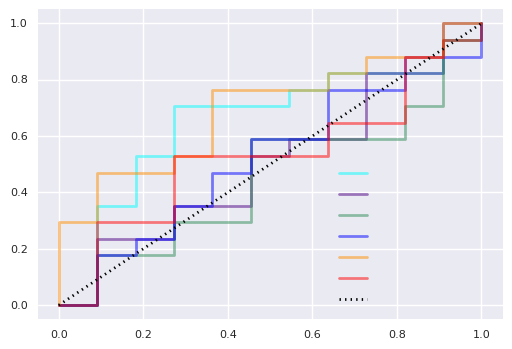

In [102]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = 10
all_features = []
roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_nodal_results = all_freq_nodal_results[fconn]
    width = len(map(lambda x: x.values(), all_nodal_results.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_nodal_results.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if patient_id == 'HUP111A':
                continue
#             print patient_id
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    if clip == '1000':
                        continue
                    if run_stereotype_only:
                        common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != common_stype:
                            continue
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                #%DEBUG
#                     print patient_id, clip, avg_data.shape
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.append([clip_iter+1],avg_data)
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                # Update header
                if(clip_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.append(row_data,[0])        
                else:
                    row_data = np.append(row_data,[1])
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                try:
                    all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                except Exception:
                    all_data = row_data
                clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmedian(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmedian(all_data[outcomex==1,:width/2],axis=1)
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,:width/2],axis=1))    
    tpr = np.loadtxt('FigureS12_pre_%s_sensitivity.csv'%fconn)
    fpr = np.loadtxt('FigureS12_pre_%s_specificity.csv'%fconn)
    fpr = 1-fpr
    
    roc_auc = auc(fpr,tpr)
    print roc_auc
    roc_results.append((fconn,roc_auc,fpr,tpr))
    np.savetxt('FigureS12_pre_%s_outcomex.csv'%fconn,outcomex)
    np.savetxt('FigureS12_pre_%s_threshold.csv'%fconn,np.nanmedian(all_data[:,:width/2],axis=1))

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'red']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
#     ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (%0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '                       ', alpha=0.5)
    print fconn, roc_auc
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label=' ')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

# ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
# ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.set_xticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.set_yticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.legend(loc="lower right",prop={'size':10,'weight':'bold', 'family':'normal'})
# plt.show()
# plt.title('Node-level control centrality',fontdict={'size':20})
if run_stereotype_only:
    blah
    plt.savefig('../../fig/FigureS20.png',bbox_inches='tight', format='png', dpi=1200)
else:
    plt.savefig('../../fig/FigureS12_pre.png',bbox_inches='tight', format='png', dpi=1200)

alphatheta -0.729125889028 0.465924659585
0.582887700535
beta -0.399843229467 0.689271988212
0.545454545455
lowgamma -0.446883609404 0.654959098972
0.550802139037
highgamma 1.15248930846 0.249120060672
0.631016042781
veryhigh -0.635045129153 0.525398982181
0.572192513369
broadband_CC -0.16464132978 0.869226298639
0.48128342246
alphatheta 0.582887700535
beta 0.545454545455
lowgamma 0.550802139037
highgamma 0.631016042781
veryhigh 0.572192513369
broadband_CC 0.48128342246


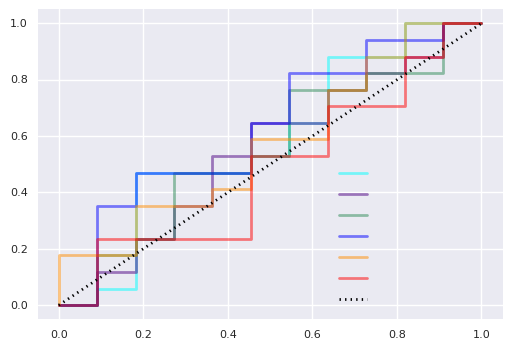

In [104]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = 10
all_features = []
roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_nodal_results = all_freq_nodal_results[fconn]
    width = len(map(lambda x: x.values(), all_nodal_results.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_nodal_results.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if patient_id == 'HUP111A':
                continue
#             print patient_id
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    if clip == '1000':
                        continue
                    if run_stereotype_only:
                        common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != common_stype:
                            continue
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                #%DEBUG
#                     print patient_id, clip, avg_data.shape
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.append([clip_iter+1],avg_data)
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                # Update header
                if(clip_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.append(row_data,[0])        
                else:
                    row_data = np.append(row_data,[1])
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                try:
                    all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                except Exception:
                    all_data = row_data
                clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmedian(all_data[outcomex==0,width/2:],axis=1)
    poor_outcome_feature = np.nanmedian(all_data[outcomex==1,width/2:],axis=1)
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1))    
    tpr = np.loadtxt('FigureS12_post_%s_sensitivity.csv'%fconn)
    fpr = np.loadtxt('FigureS12_post_%s_specificity.csv'%fconn)
    fpr = 1-fpr
    
    roc_auc = auc(fpr,tpr)
    print roc_auc
    roc_results.append((fconn,roc_auc,fpr,tpr))
    np.savetxt('FigureS12_post_%s_outcomex.csv'%fconn,outcomex)
    np.savetxt('FigureS12_post_%s_threshold.csv'%fconn,np.nanmedian(all_data[:,width/2:],axis=1))

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'red']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
#     ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (%0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '                       ', alpha=0.5)
    print fconn, roc_auc
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label=' ')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

# ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
# ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.set_xticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.set_yticklabels([0.0,0.0,0.2,0.4,0.6,0.8,1.0],fontdict={'size':8,'family':'normal'})
ax.legend(loc="lower right",prop={'size':10,'weight':'bold', 'family':'normal'})
# plt.show()
# plt.title('Node-level control centrality',fontdict={'size':20})
if run_stereotype_only:
    blah
    plt.savefig('../../fig/FigureS20.png',bbox_inches='tight', format='png', dpi=1200)
else:
    plt.savefig('../../fig/FigureS12_post.png',bbox_inches='tight', format='png', dpi=1200)

<h1>Figure S??. Distribution of Asymmetry Index of mean node-level control centrality </h1>

In [11]:
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

# Collect data
# Initialize boxplot arrays
good_pre_res = {}
good_res = {}
poor_pre_res = {}
poor_res = {}

for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)
    try:
        good_pre_res[fconn]        
    except KeyError:
        good_pre_res[fconn] = []
        good_res[fconn] = []
        poor_pre_res[fconn] = []
        poor_res[fconn] = []
    for patient_id in PATIENT_IDX:
        # Get outcome
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        pre_res = []
        res = []
        
        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, channels = get_resected_node_dx(patient_id)
        non_resected_node_idx = []
        for k in range(nodal_control_centrality.shape[0]):
            if k not in resected_node_idx:
                non_resected_node_idx.append(k)

        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                if stype != common_stype:
                    continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes>0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                if not np.isnan(ai):
                    pre_res.append(ai)
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes>0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                if not np.isnan(ai):
                    res.append(ai)


            good_pre_res[fconn].append(np.nanmean(pre_res))
            good_res[fconn].append(np.nanmean(res))
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
#                 print patient_id, clip_id
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes>0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                if not np.isnan(ai):
                    pre_res.append(ai)

                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue
                
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                positive_nodes = mean_nodal_control_centrality[resected_node_idx]
                positive_nodes = positive_nodes[positive_nodes>0]
                negative_nodes = mean_nodal_control_centrality[non_resected_node_idx]
                negative_nodes = negative_nodes[negative_nodes>0]
                ai = (np.abs(np.nanmedian(positive_nodes))-np.abs(np.nanmedian(negative_nodes)))/(np.abs(np.nanmedian(positive_nodes))+np.abs(np.nanmedian(negative_nodes)))
                if not np.isnan(ai):
                    res.append(ai)
                
            poor_pre_res[fconn].append(np.nanmean(pre_res))
            poor_res[fconn].append(np.nanmean(res))
            

In [12]:
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    poor_pre_res[fconn] = [x for x in poor_pre_res[fconn] if str(x) != 'nan']
    good_pre_res[fconn] = [x for x in good_pre_res[fconn] if str(x) != 'nan']
    
    poor_res[fconn] = [x for x in poor_res[fconn] if str(x) != 'nan']
    good_res[fconn] = [x for x in good_res[fconn] if str(x) != 'nan']
    

Alpha/Theta:
 5-15 Hz pre 0.134839972493 0.892738400944 0.00804359903967
Alpha/Theta:
 5-15 Hz post 0.674199862463 0.500184257071 0.158272904461
Beta:
 15-25 Hz pre -0.444117394098 0.65695771132 -0.16280325972
Beta:
 15-25 Hz post -0.305762469592 0.759785505665 -0.0965619769215
Low Gamma:
 30-40 Hz pre 0.441149401692 0.659104841083 0.280136471428
Low Gamma:
 30-40 Hz post -0.87024702884 0.384165420205 -0.372446687841
High Gamma:
 95-105 Hz pre 0.540964369279 0.588532141899 0.255556991967
High Gamma:
 95-105 Hz post 0.540964369279 0.588532141899 0.304337921912
Very High:
 105-256+ Hz pre -0.399843229467 0.689271988212 -0.184012846315
Very High:
 105-256+ Hz post -1.39334638242 0.163515071079 -0.523909898071
Broadband
 Cross-Correlation pre -0.0502096445253 0.95995532603 -0.01517799113
Broadband
 Cross-Correlation post -0.87024702884 0.384165420205 -0.28176716895


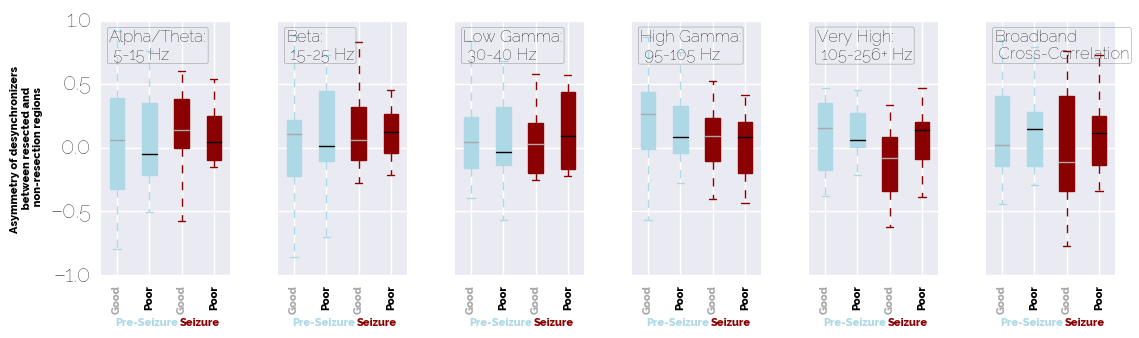

In [13]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 1.0
# max_y = 3.0
min_y = -1.0
# min_y = -3.0
star_y = -0.85


# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
# fig.set_figwidth(2.75591)
fig.set_size_inches((12,4))
# fig.suptitle('Resection ',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Asymmetry of desynchronizers \n between resected and \n non-resection regions',fontdict={'size':8,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd

    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.15:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.15:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
plt.show()
# fig.savefig('%s/../fig/FigureS??.png'%(comp_dir))

<h1>Figure S12/21. Distribution of mean ABSOLUTE VALUE node-level control centrality </h1>

In [39]:
run_stereotype_only = True
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

# Collect data
# Initialize boxplot arrays
good_pre_res = {}
good_res = {}
poor_pre_res = {}
poor_res = {}

for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)
    try:
        good_pre_res[fconn]        
    except KeyError:
        good_pre_res[fconn] = []
        good_res[fconn] = []
        poor_pre_res[fconn] = []
        poor_res[fconn] = []
    for patient_id in PATIENT_IDX:
        # Get outcome
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        pre_res = []
        res = []
        
        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, channels = get_resected_node_dx(patient_id)

        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = np.abs(all_nodal_results[patient_id][clip_id])
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                
                pre_res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
    
                try:
                    nodal_control_centrality = np.abs(all_nodal_results[patient_id][clip_id])
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                
                res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))


            good_pre_res[fconn].append(np.nanmean(pre_res))
            good_res[fconn].append(np.nanmean(res))
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 print patient_id, clip_id
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = np.abs(all_nodal_results[patient_id][clip_id])
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)

                pre_res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))

                try:
                    nodal_control_centrality = np.abs(all_nodal_results[patient_id][clip_id])
                except KeyError:
                    continue
                
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                
                res.append(np.nanmean(mean_nodal_control_centrality[resected_node_idx]))
                
            poor_pre_res[fconn].append(np.nanmean(pre_res))
            poor_res[fconn].append(np.nanmean(res))
            

Alpha/Theta:
 5-15 Hz pre -0.629253204966 0.529183301709 -0.440359530315
Alpha/Theta:
 5-15 Hz post -0.898933149951 0.368688269362 -0.581798123016
Beta:
 15-25 Hz pre 0.0449466574975 0.964149827095 -0.310479918557
Beta:
 15-25 Hz post -0.853986492453 0.393112473666 -0.539106041487
Low Gamma:
 30-40 Hz pre 0.0449466574975 0.964149827095 -0.248968970417
Low Gamma:
 30-40 Hz post -0.988826464946 0.322748053511 -0.533811095052
High Gamma:
 95-105 Hz pre -0.449466574975 0.653095114932 -0.240645835285
High Gamma:
 95-105 Hz post -0.809039834956 0.418492233447 -0.53282192055
Very High:
 105-256+ Hz pre -1.66302632741 0.096307165586 -0.64398203081
Very High:
 105-256+ Hz post -0.898933149951 0.368688269362 -0.548283127948
Broadband
 Cross-Correlation pre -0.494413232473 0.621014370661 -0.367080462685
Broadband
 Cross-Correlation post -0.494413232473 0.621014370661 -0.531685842503


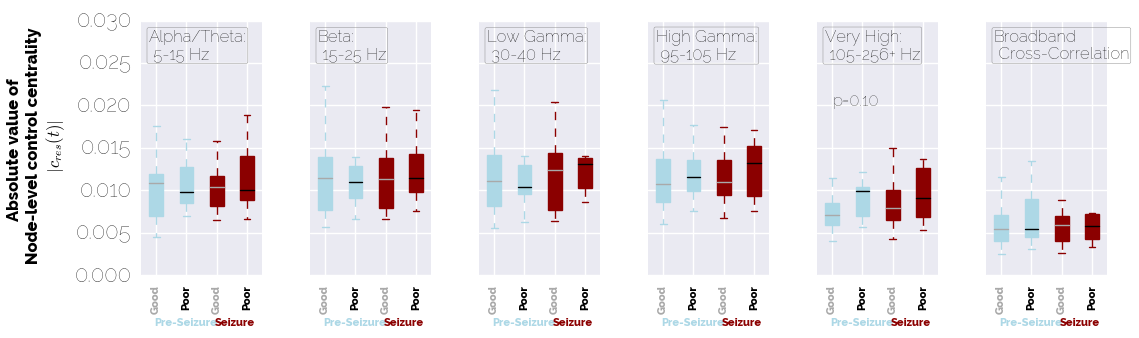

In [40]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.03
# max_y = 3.0
min_y = 0.0
# min_y = -3.0
star_y = 0.02


# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
# fig.set_figwidth(2.75591)
fig.set_size_inches((12,4))
# fig.suptitle('Resection ',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Absolute value of \n Node-level control centrality\n $|c_{res}(t)|$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd

    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
# plt.show()
if run_stereotype_only:
    fig.savefig('%s/../fig/FigureS21.png'%(comp_dir))
else:
    fig.savefig('%s/../fig/FigureS12.png'%(comp_dir))



<h1>Figure S13/S22. Distribution of mean POSITIVE ONLY node-level control centrality </h1>

In [106]:
run_stereotype_only = False
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

# Collect data
# Initialize boxplot arrays
good_pre_res = {}
good_res = {}
poor_pre_res = {}
poor_res = {}

for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)
    try:
        good_pre_res[fconn]        
    except KeyError:
        good_pre_res[fconn] = []
        good_res[fconn] = []
        poor_pre_res[fconn] = []
        poor_res[fconn] = []
    for patient_id in PATIENT_IDX:
        if patient_id == 'HUP111A':
            continue
        if len(data['PATIENTS'][patient_id]['ELECTRODE_LABELS'].split('/')[-1].split('_')) <= 3:
            continue
        # Get outcome
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        pre_res = []
        res = []
        
        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, non_resected_node_idx, channels = get_resected_node_dx(patient_id)

        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if clip_id == '1000':
                    continue
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality>0]
                pre_res.append(np.nanmedian(mean_nodal_control_centrality))
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality>0]
                res.append(np.nanmedian(mean_nodal_control_centrality))


            good_pre_res[fconn].append(np.nanmedian(pre_res))
            good_res[fconn].append(np.nanmedian(res))
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if clip_id == '1000':
                    continue
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 print patient_id, clip_id
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality>0]
                pre_res.append(np.nanmedian(mean_nodal_control_centrality))

                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue
                
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality>0]
                res.append(np.nanmedian(mean_nodal_control_centrality))
                
            poor_pre_res[fconn].append(np.nanmedian(pre_res))
            poor_res[fconn].append(np.nanmedian(res))
            

In [107]:
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    poor_pre_res[fconn] = [x for x in poor_pre_res[fconn] if str(x) != 'nan']
    good_pre_res[fconn] = [x for x in good_pre_res[fconn] if str(x) != 'nan']
    
    poor_res[fconn] = [x for x in poor_res[fconn] if str(x) != 'nan']
    good_res[fconn] = [x for x in good_res[fconn] if str(x) != 'nan']
    

Alpha/Theta:
 5-15 Hz pre -1.26491106407 0.205903210732 -0.215831184106
Alpha/Theta:
 5-15 Hz post 0.105409255339 0.916051072282 -0.178428128482
Beta:
 15-25 Hz pre -0.632455532034 0.527089256866 -0.0171565488989
Beta:
 15-25 Hz post -1.08562029668 0.277647016276 -0.176040993968
Low Gamma:
 30-40 Hz pre 0.351324026261 0.725345271991 0.350813846496
Low Gamma:
 30-40 Hz post -0.0778498944162 0.937947456843 0.224908476585
High Gamma:
 95-105 Hz pre -0.0778498944162 0.937947456843 0.119994224504
High Gamma:
 95-105 Hz post -0.197385508488 0.843525869093 -0.00102547079191
Very High:
 105-256+ Hz pre -2.51666032664 0.0118472984628 -1.10664443979
Very High:
 105-256+ Hz post -0.87024702884 0.384165420205 -0.345277966619
Broadband
 Cross-Correlation pre -0.579750904364 0.562082610035 0.0812296003059
Broadband
 Cross-Correlation post 0.0 1.0 0.0507261156048


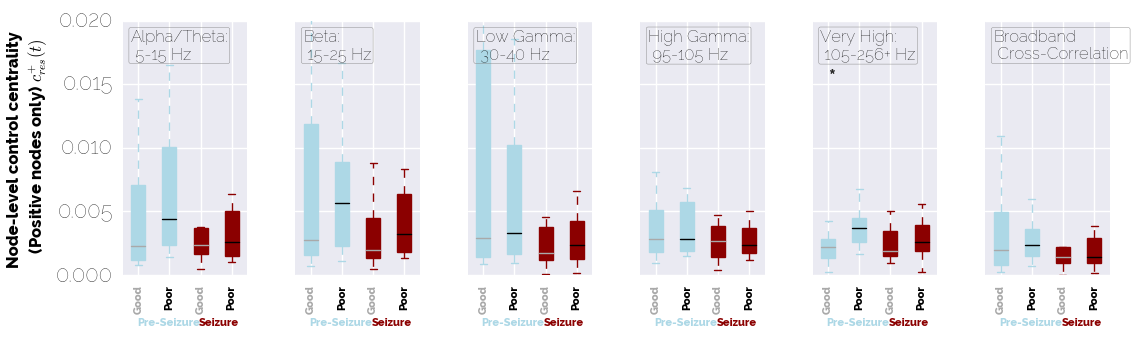

In [108]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.02
# max_y = 3.0
min_y = -0.0
# min_y = -3.0
star_y = 0.015


# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
# fig.set_figwidth(2.75591)
fig.set_size_inches((12,4))
# fig.suptitle('Resection ',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level control centrality \n (Positive nodes only) $c^{+}_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd

    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
# plt.show()
if run_stereotype_only:
    blah
    fig.savefig('%s/../fig/FigureS22.png'%(comp_dir))
else:
    fig.savefig('%s/../fig/FigureS14.png'%(comp_dir))



<h1>Figure S14/S23. Distribution of mean NEGATIVE ONLY node-level control centrality </h1>

In [44]:
run_stereotype_only = True
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = sorted(all_nodal_results.keys())
comp_dir = os.path.expanduser(data['COMP_DIR'])

# Collect data
# Initialize boxplot arrays
good_pre_res = {}
good_res = {}
poor_pre_res = {}
poor_res = {}

for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)
    try:
        good_pre_res[fconn]        
    except KeyError:
        good_pre_res[fconn] = []
        good_res[fconn] = []
        poor_pre_res[fconn] = []
        poor_res[fconn] = []
    for patient_id in PATIENT_IDX:
        # Get outcome
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        pre_res = []
        res = []
        
        # Get resected nodes and non-resected nodes
        first_clip_id = data['PATIENTS'][patient_id]['Events']['Ictal'].keys()[0]
        nodal_control_centrality = all_nodal_results[patient_id][first_clip_id]
        resected_node_idx, channels = get_resected_node_dx(patient_id)

        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality<0]
                pre_res.append(np.nanmean(mean_nodal_control_centrality))
    
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality<0]
                res.append(np.nanmean(mean_nodal_control_centrality))


            good_pre_res[fconn].append(np.nanmean(pre_res))
            good_res[fconn].append(np.nanmean(res))
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                if run_stereotype_only:
                    common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                    stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                    if stype != common_stype:
                        continue
#                 print patient_id, clip_id
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
#                 if stype not in ['A','B','C','D']:
#                     continue
#                 stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
#                 if 'CPS' not in stype or stype == '??':
#                     continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality<0]
                pre_res.append(np.nanmean(mean_nodal_control_centrality))

                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue
                
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx]
                mean_nodal_control_centrality = mean_nodal_control_centrality[mean_nodal_control_centrality<0]
                res.append(np.nanmean(mean_nodal_control_centrality))
                
            poor_pre_res[fconn].append(np.nanmean(pre_res))
            poor_res[fconn].append(np.nanmean(res))
            

In [45]:
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    poor_pre_res[fconn] = [x for x in poor_pre_res[fconn] if str(x) != 'nan']
    good_pre_res[fconn] = [x for x in good_pre_res[fconn] if str(x) != 'nan']
    
    poor_res[fconn] = [x for x in poor_res[fconn] if str(x) != 'nan']
    good_res[fconn] = [x for x in good_res[fconn] if str(x) != 'nan']
    

Alpha/Theta:
 5-15 Hz pre 0.823206648902 0.410390488491 0.46774064677
Alpha/Theta:
 5-15 Hz post 1.01136816865 0.31184025033 0.488269674265
Beta:
 15-25 Hz pre 0.269679944985 0.787406490666 0.388437117695
Beta:
 15-25 Hz post -0.588004749216 0.556529105076 0.11752378026
Low Gamma:
 30-40 Hz pre 0.258722089655 0.79584967464 0.446946967821
Low Gamma:
 30-40 Hz post -0.449466574975 0.653095114932 0.253413521362
High Gamma:
 95-105 Hz pre 1.15248930846 0.249120060672 0.441052660615
High Gamma:
 95-105 Hz post 0.049346377122 0.960643260913 0.13417325686
Very High:
 105-256+ Hz pre 0.652725378829 0.513933338115 0.0928026312896
Very High:
 105-256+ Hz post 1.39334638242 0.163515071079 0.618005538005
Broadband
 Cross-Correlation pre 0.345424639854 0.729775155917 0.215961660428
Broadband
 Cross-Correlation post 0.0235201899686 0.981235333673 0.200044813581


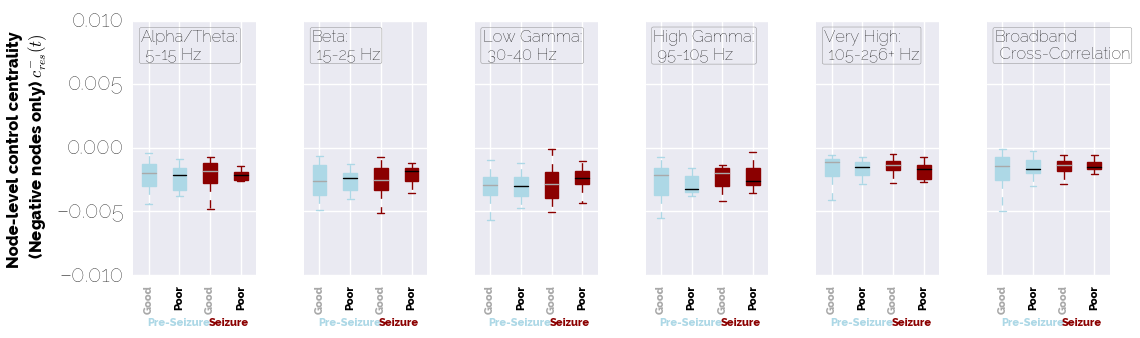

In [46]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.01
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = -0.0095


# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
# fig.set_figwidth(2.75591)
fig.set_size_inches((12,4))
# fig.suptitle('Resection ',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level control centrality \n (Negative nodes only) $c^{-}_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    cd = cohen_d(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    cd = cohen_d(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p, cd

    ax.text(0.95,min_y-(max_y-min_y)*0.2,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.2,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
# plt.show()
if run_stereotype_only:
    fig.savefig('%s/../fig/FigureS23.png'%(comp_dir))
else:
    fig.savefig('%s/../fig/FigureS14.png'%(comp_dir))

<h1> Figure S??. Lesional versus Perilesional Analysis </h1>

In [23]:
run_stereotype_only = False

all_results = {}
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:



    ptx = ['HUP064','HUP065','HUP070','HUP073','HUP074']

    with open('../data/DATA.json') as json_data_file:
        data = json.load(json_data_file)

    # initialize final arrays
    pre_resection0 = []
    pre_resection_diff10 = []
    resection0 = []
    resection_diff10 = []
    for patient_id in ptx:
        ### Get original resected nodes

        # Generate list of cartoon map labels
        labels = map(lambda x: x.split(',')[4].replace('\n',''), open(os.path.expanduser(
            data['PATIENTS'][patient_id]['ELECTRODE_LABELS']
            ),'r').readlines())

        # Get path
        comp_dir = os.path.expanduser(data['COMP_DIR'])
        data_dir = os.path.expanduser(data['DATA_DIR'])

        # Load ignored node labels
        ignored_node_labels = data['PATIENTS'][patient_id]['IGNORE_ELECTRODES']
        for ignored_node_label in ignored_node_labels:
            if(ignored_node_label not in labels):
                labels.append(ignored_node_label)

        # Create output UUID codx
        unique_idx = []

        # Initialzie result arrays
        patient_pre_resection0 = []
        patient_pre_resection_diff10 = []
        patient_resection0 = []
        patient_resection_diff10 = []
        # Load ictal clips and get data as T x N for T = epoch_length (seconds) * fs
        for event_type, events in data['PATIENTS'][patient_id]['Events'].items():
            unique_id = str(uuid.uuid4())
            for event_id in events.keys():
                if event_id == "1000":
                    continue
                try:
                    if(events[event_id]['STATUS'] == 'ALL_DROPOUT'):
                            continue # unusable clip
                except KeyError:
                    pass

                fn = os.path.join(data_dir, patient_id, 'eeg', events[event_id]['FILE'])
                channels = []

                # Get channels, ECoG Data, Fsx
                with h5py.File(fn) as f:
                    evData = f['evData'].value
                    Fs = f['Fs'].value
                    for column in f['channels']:
                        row_data = []
                        for row_number in range(len(column)):
                            row_data.append(''.join(map(unichr, f[column[row_number]][:])))
                        channels.append(row_data)
                Fs = int(Fs[0][0])
                channels = channels[0]

                T = evData.shape[0]

                # Correspond label names
                labels_dict = correspond_label_names(channels, labels)

                # Load electrodes to ignore
                ignored_node_idx  = map(lambda x: labels_dict[x][0], ignored_node_labels)
                for ii,node_id in enumerate(ignored_node_idx):
                    pass

                channels = list(np.delete(np.array(channels),ignored_node_idx))

                # Recorrespond label names
                labels_dict = correspond_label_names(channels, labels)

                dilate_radius = 0
                resected_node_idx_0,non_resected_node_idx_0,channels = get_resected_node_dx(patient_id,dilate_radius)

                dilate_radius = 5
                resected_node_idx_10,non_resected_node_idx_10,channels = get_resected_node_dx(patient_id,dilate_radius)

                difference_nodes = list(set(resected_node_idx_10)-set(resected_node_idx_0))

                # PRE-ICTAL
                all_nodal_results = gather_nodal_results(fconn=fconn)
                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[difference_nodes]
                patient_pre_resection_diff10.append(np.nanmedian(mean_nodal_control_centrality))

                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx_0]
                patient_pre_resection0.append(np.nanmedian(mean_nodal_control_centrality))


                # ICTAL
                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[difference_nodes]
                patient_resection_diff10.append(np.nanmedian(mean_nodal_control_centrality))


                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx_0]
                patient_resection0.append(np.nanmedian(mean_nodal_control_centrality))

            resection0.append(np.nanmedian(patient_resection0))
            resection_diff10.append(np.nanmedian(patient_resection_diff10))
            pre_resection0.append(np.nanmedian(patient_pre_resection0))
            pre_resection_diff10.append(np.nanmedian(patient_pre_resection_diff10))

            lesional_pre_resection0, lesional_pre_resection_diff10 = pre_resection0, pre_resection_diff10
            lesional_resection0, lesional_resection_diff10 = resection0, resection_diff10

    ptx = ['HUP080','HUP086','HUP094','Study028','Study029', 'HUP068', 'HUP075', 'HUP106', 'HUP107', 'HUP111B']

    with open('../data/DATA.json') as json_data_file:
        data = json.load(json_data_file)

    # initialize final arrays
    pre_resection0 = []
    pre_resection_diff10 = []
    resection0 = []
    resection_diff10 = []
    for patient_id in ptx:
        ### Get original resected nodes

        # Generate list of cartoon map labels
        labels = map(lambda x: x.split(',')[4].replace('\n',''), open(os.path.expanduser(
            data['PATIENTS'][patient_id]['ELECTRODE_LABELS']
            ),'r').readlines())

        # Get path
        comp_dir = os.path.expanduser(data['COMP_DIR'])
        data_dir = os.path.expanduser(data['DATA_DIR'])

        # Load ignored node labels
        ignored_node_labels = data['PATIENTS'][patient_id]['IGNORE_ELECTRODES']
        for ignored_node_label in ignored_node_labels:
            if(ignored_node_label not in labels):
                labels.append(ignored_node_label)

        # Create output UUID codx
        unique_idx = []

        # Initialzie result arrays
        patient_pre_resection0 = []
        patient_pre_resection_diff10 = []
        patient_resection0 = []
        patient_resection_diff10 = []
        # Load ictal clips and get data as T x N for T = epoch_length (seconds) * fs
        for event_type, events in data['PATIENTS'][patient_id]['Events'].items():
            unique_id = str(uuid.uuid4())
            for event_id in events.keys():
                if event_id == "1000":
                    continue
                try:
                    if(events[event_id]['STATUS'] == 'ALL_DROPOUT'):
                            continue # unusable clip
                except KeyError:
                    pass

                fn = os.path.join(data_dir, patient_id, 'eeg', events[event_id]['FILE'])
                channels = []

                # Get channels, ECoG Data, Fsx
                with h5py.File(fn) as f:
                    evData = f['evData'].value
                    Fs = f['Fs'].value
                    for column in f['channels']:
                        row_data = []
                        for row_number in range(len(column)):
                            row_data.append(''.join(map(unichr, f[column[row_number]][:])))
                        channels.append(row_data)
                Fs = int(Fs[0][0])
                channels = channels[0]

                T = evData.shape[0]

                # Correspond label names
                labels_dict = correspond_label_names(channels, labels)

                # Load electrodes to ignore
                ignored_node_idx  = map(lambda x: labels_dict[x][0], ignored_node_labels)
                for ii,node_id in enumerate(ignored_node_idx):
                    pass

                channels = list(np.delete(np.array(channels),ignored_node_idx))

                # Recorrespond label names
                labels_dict = correspond_label_names(channels, labels)

                dilate_radius = 0
                resected_node_idx_0,non_resected_node_idx_0,channels = get_resected_node_dx(patient_id,dilate_radius)

                dilate_radius = 5
                resected_node_idx_10,non_resected_node_idx_10,channels = get_resected_node_dx(patient_id,dilate_radius)

                difference_nodes = list(set(resected_node_idx_10)-set(resected_node_idx_0))

                # PRE-ICTAL
                all_nodal_results = gather_nodal_results(fconn=fconn)
                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[difference_nodes]
                patient_pre_resection_diff10.append(np.nanmedian(mean_nodal_control_centrality))

                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx_0]
                patient_pre_resection0.append(np.nanmedian(mean_nodal_control_centrality))


                # ICTAL
                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[difference_nodes]
                patient_resection_diff10.append(np.nanmedian(mean_nodal_control_centrality))


                nodal_control_centrality = all_nodal_results[patient_id][event_id]
                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.nanmedian(nodal_control_centrality, axis=1)
#                 mean_nodal_control_centrality = scipy.stats.zscore(mean_nodal_control_centrality)
                mean_nodal_control_centrality = mean_nodal_control_centrality[resected_node_idx_0]
                patient_resection0.append(np.nanmedian(mean_nodal_control_centrality))

            resection0.append(np.nanmedian(patient_resection0))
            resection_diff10.append(np.nanmedian(patient_resection_diff10))
            pre_resection0.append(np.nanmedian(patient_pre_resection0))
            pre_resection_diff10.append(np.nanmedian(patient_pre_resection_diff10))

            non_lesional_pre_resection0, non_lesional_pre_resection_diff10 = pre_resection0, pre_resection_diff10
            non_lesional_resection0, non_lesional_resection_diff10 = resection0, resection_diff10

    print fconn
    print scipy.stats.ranksums(lesional_pre_resection_diff10,non_lesional_pre_resection_diff10)
    print scipy.stats.ranksums(lesional_resection_diff10,non_lesional_resection_diff10)
    all_results[fconn] = {}
    all_results[fconn]['lesional_pre_resection_diff10'] = lesional_pre_resection_diff10
    all_results[fconn]['lesional_pre_resection0'] = lesional_pre_resection0
    all_results[fconn]['lesional_resection_diff10'] = lesional_resection_diff10
    all_results[fconn]['lesional_resection0'] = lesional_resection0
    all_results[fconn]['non_lesional_pre_resection_diff10'] = non_lesional_pre_resection_diff10
    all_results[fconn]['non_lesional_pre_resection0'] = non_lesional_pre_resection0
    all_results[fconn]['non_lesional_resection_diff10'] = non_lesional_resection_diff10
    all_results[fconn]['non_lesional_resection0'] = non_lesional_resection0
    


alphatheta
RanksumsResult(statistic=0.4898979485566356, pvalue=0.62420611476640597)
RanksumsResult(statistic=0.9797958971132712, pvalue=0.32718687779030575)
beta
RanksumsResult(statistic=0.0, pvalue=1.0)
RanksumsResult(statistic=1.7146428199482247, pvalue=0.0864107329737)
lowgamma
RanksumsResult(statistic=-0.73484692283495334, pvalue=0.46243272645047639)
RanksumsResult(statistic=1.2247448713915889, pvalue=0.22067136191984693)
highgamma
RanksumsResult(statistic=-1.4696938456699067, pvalue=0.14164469029513679)
RanksumsResult(statistic=0.9797958971132712, pvalue=0.32718687779030575)
veryhigh
RanksumsResult(statistic=-2.0820662813657012, pvalue=0.037336415920662877)
RanksumsResult(statistic=-0.1224744871391589, pvalue=0.90252325017767943)
broadband_CC
RanksumsResult(statistic=0.2449489742783178, pvalue=0.80649594050734008)
RanksumsResult(statistic=1.2247448713915889, pvalue=0.22067136191984693)


Alpha/Theta:
 5-15 Hz pre 0.489897948557 0.624206114766 0.00243041477031
Alpha/Theta:
 5-15 Hz post 0.979795897113 0.32718687779 0.11710872651
Beta:
 15-25 Hz pre 0.0 1.0 -0.0216057395462
Beta:
 15-25 Hz post 1.71464281995 0.0864107329737 1.3167657233
Low Gamma:
 30-40 Hz pre -0.734846922835 0.46243272645 -0.273515478782
Low Gamma:
 30-40 Hz post 1.22474487139 0.22067136192 1.00963654698
High Gamma:
 95-105 Hz pre -1.46969384567 0.141644690295 -0.976574828353
High Gamma:
 95-105 Hz post 0.979795897113 0.32718687779 0.139175466358
Very High:
 105-256+ Hz pre -2.08206628137 0.0373364159207 -1.33345674451
Very High:
 105-256+ Hz post -0.122474487139 0.902523250178 0.000877684394619
Broadband
 Cross-Correlation pre 0.244948974278 0.806495940507 0.0617430135568
Broadband
 Cross-Correlation post 1.22474487139 0.22067136192 0.86834646961


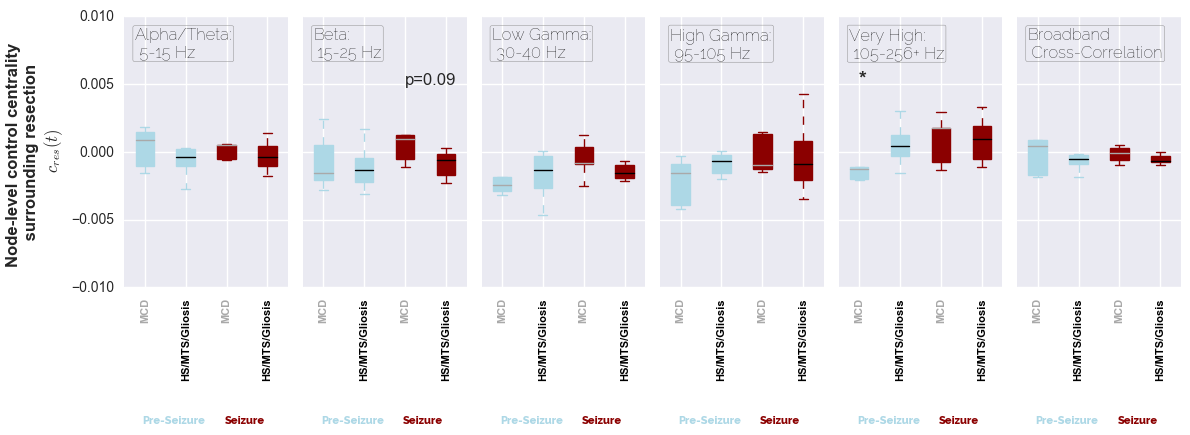

In [25]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }

max_y = 0.01
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = 0.005


# Make function to change boxplot colors
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
#     print bp['boxes']
    for element in ['boxes','whiskers','fliers','medians','caps']:
        for i in range(len(bp[element])):                
            if element is 'medians':
                plt.setp(bp[element][i], color=fill_color[i][1])
            elif element is 'whiskers' or element is 'caps':
                plt.setp(bp[element][i], color=edge_color[i/2])
            else:
                plt.setp(bp[element][i], color=edge_color[i])
    for i,patch in enumerate(bp['boxes']):
        patch.set(hatch=fill_color[i][0])

fig,axs = plt.subplots(1,6,sharey=True)
# fig.set_figwidth(2.75591)
fig.set_size_inches((12,4))
# fig.suptitle('Resection ',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level control centrality \n surrounding resection \n $c_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

#     ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    draw_plot([all_results[fconn]['lesional_pre_resection_diff10'],all_results[fconn]['non_lesional_pre_resection_diff10'],all_results[fconn]['lesional_resection_diff10'],all_results[fconn]['non_lesional_resection_diff10']],
              ['lightblue','lightblue','darkred','darkred'],
              [('/','darkgray'),('/','black'),('/','darkgray'),('/','black')])
    s,pre_p = scipy.stats.ranksums(all_results[fconn]['lesional_pre_resection_diff10'], all_results[fconn]['non_lesional_pre_resection_diff10'])
    cd = cohen_d(all_results[fconn]['lesional_pre_resection_diff10'], all_results[fconn]['non_lesional_pre_resection_diff10'])
    print title, 'pre', s,pre_p, cd
    s,post_p = scipy.stats.ranksums(all_results[fconn]['lesional_resection_diff10'], all_results[fconn]['non_lesional_resection_diff10'])
    cd = cohen_d(all_results[fconn]['lesional_resection_diff10'], all_results[fconn]['non_lesional_resection_diff10'])
    print title, 'post',s,post_p, cd

    ax.text(0.95,min_y-(max_y-min_y)*0.5,'Pre-Seizure',fontdict=font1)
    ax.text(2.95,min_y-(max_y-min_y)*0.5,'Seizure',fontdict=font2)
    ax.text(0.75, max_y-(max_y-min_y)*0.15,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['MCD','HS/MTS/Gliosis','MCD','HS/MTS/Gliosis'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,star_y,'***',{'weight':'bold', 'size':14})
    elif pre_p < 0.01:
        ax.text(1.0,star_y,'**',{'weight':'bold', 'size':14})
    elif pre_p < 0.05:
        ax.text(1.0,star_y,'*',{'weight':'bold', 'size':14})
    elif pre_p < 0.1:
        ax.text(1.0,star_y,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,star_y,'***',{'weight':'bold', 'size':14})
    elif post_p < 0.01:
        ax.text(3.0,star_y,'**',{'weight':'bold', 'size':14})
    elif post_p < 0.05:
        ax.text(3.0,star_y,'*',{'weight':'bold', 'size':14})
    elif post_p < 0.1:
        ax.text(3.0,star_y,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
plt.show()
if run_stereotype_only:
    blah    
else:
#     blah
    fig.savefig('%s/../fig/FigureS??lesion.png'%(comp_dir))

<h1>Figure S11/S20. ROC Curve of using change in mean node-level control centrality in the resection zone </h1>

In [54]:
run_stereotype_only = False
width = 10
all_freq_nodal_results = {}
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:
    all_freq_nodal_results[fconn] = gather_resection_norm_nodal_results(fconn=fconn,width=width)

IOError: [Errno 2] No such file or directory: u'??'

KeyError: 'alphatheta'

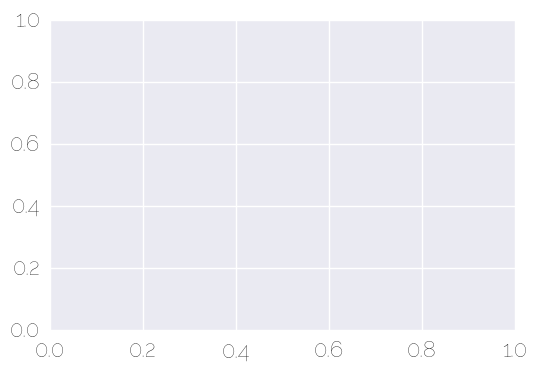

In [48]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = 10
all_features = []
roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','veryhigh','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_nodal_results = all_freq_nodal_results[fconn]
    width = len(map(lambda x: x.values(), all_nodal_results.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_nodal_results.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    if run_stereotype_only:
                        common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != common_stype:
                            continue
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                #%DEBUG
#                     print patient_id, clip, avg_data.shape
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.append([clip_iter+1],avg_data)
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                # Update header
                if(clip_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.append(row_data,[0])        
                else:
                    row_data = np.append(row_data,[1])
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                try:
                    all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                except Exception:
                    all_data = row_data
                clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmedian(all_data[outcomex==0,width/2:],axis=1)-np.nanmedian(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmedian(all_data[outcomex==1,width/2:],axis=1)-np.nanmedian(all_data[outcomex==1,:width/2],axis=1)
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    roc_results.append((fconn,roc_auc,fpr,tpr))
    

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'red']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (%0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label='Luck')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

# ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
# ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.legend(loc="lower right",prop={'size':10,'weight':'bold', 'family':'normal'})
# plt.show()
# plt.title('Node-level control centrality',fontdict={'size':20})
if run_stereotype_only:
    plt.savefig('../../fig/FigureS20.png',bbox_inches='tight', format='png', dpi=1200)
else:
    plt.savefig('../../fig/FigureS11.png',bbox_inches='tight', format='png', dpi=1200)

<h1> NEWEST Resection Variance Plaot </h1>

In [126]:
all_features = []
roc_results = []
fconn = 'beta'
for dilate_radius in [-20,-15,-10,-5,0,5,10,15,20]:
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'
        
    run_stereotype_only = False
    width = 10
    all_freq_nodal_results = {}
    
    all_freq_nodal_results[fconn] = gather_resection_norm_nodal_results(fconn=fconn,width=width,dilate_radius=dilate_radius)

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    
    all_nodal_results = all_freq_nodal_results[fconn]
    num_fts = width

    clip_iter = 0
    patient_idx = all_nodal_results.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_nodal_results.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_nodal_results.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    if np.isnan(np.nanmean(clip_data)):
                        continue
                    if run_stereotype_only:
                        common_stype = scipy.stats.mode(map(lambda x: x['SeizurePhenotype'], data['PATIENTS'][patient_id]['Events']['Ictal'].values()))[0][0]
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != common_stype:
                            continue
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                #%DEBUG
#                     print patient_id, clip, avg_data.shape
                if avg_data.size == 0:
                    continue
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.append([clip_iter+1],avg_data)
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                # Update header
                if(clip_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.append(row_data,[0])        
                else:
                    row_data = np.append(row_data,[1])
                row_data = np.reshape(row_data, (row_data.shape[0],1))
                try:
                    all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                except Exception:
                    all_data = row_data
                clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmedian(all_data[outcomex==0,width/2:],axis=1)-np.nanmedian(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmedian(all_data[outcomex==1,width/2:],axis=1)-np.nanmedian(all_data[outcomex==1,:width/2],axis=1)

    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    roc_results.append((dilate_radius,all_data,outcomex,roc_auc,fpr,tpr))
    


beta 0.4472135955 0.654720846019
beta 0.333333333333 0.738882680364
beta 0.0333890281647 0.973364359042
beta -0.752548979356 0.451720986717
beta -1.34839972493 0.177529852412
beta -0.898933149951 0.368688269362
beta -0.988826464946 0.322748053511
beta -0.943879807449 0.345231071772
beta -0.17978662999 0.857320080306


In [127]:
for roc_result in roc_results:
    print roc_result[0],roc_result[3]

-20 0.4
-15 0.444444444444
-10 0.495726495726
-5 0.587878787879
0 0.651515151515
5 0.60101010101
10 0.611111111111
15 0.606060606061
20 0.520202020202


0.4289 0.3192 0.4
0.7613 0.856 0.444444444444
0.5173 0.0 0.495726495726
0.9109 0.0 0.587878787879
0.7616 0.0 0.651515151515
0.5583 0.0 0.60101010101
0.5182 0.0 0.611111111111
0.4512 0.0 0.606060606061
0.3709 0.0 0.520202020202


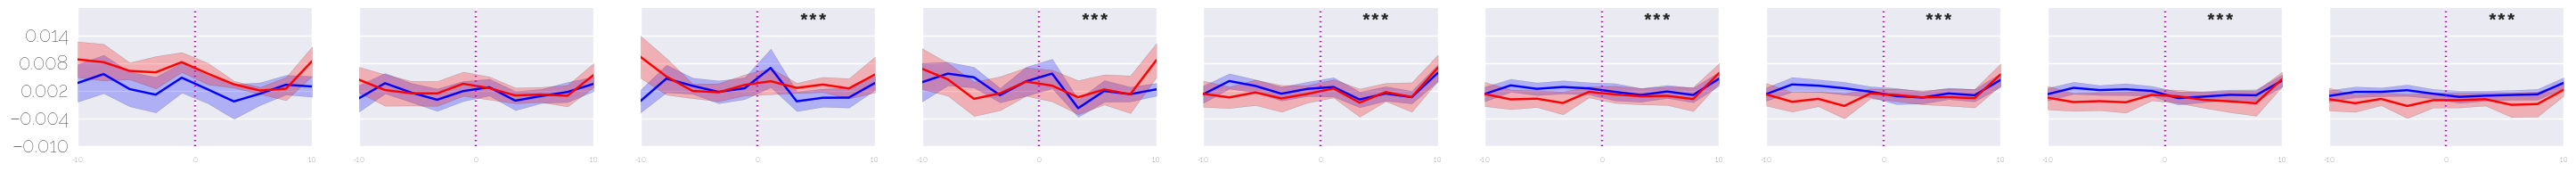

In [128]:
# Generate sem plots
max_y = 0.02
# max_y = 3.0
min_y = -0.01
# min_y = -3.0
star_y = 0.015

fig,axs = plt.subplots(1,9,sharey=True, sharex=True)
fig.set_size_inches((36,2))

fconn = 'beta'

for ii,dilate_radius in enumerate([-20,-15,-10,-5,0,5,10,15,20]):
    assert roc_results[ii][0] == dilate_radius
    
    all_data = roc_results[ii][1]
    outcomex = roc_results[ii][2]
    
    
    width = 10

    # Figure font options
    font1 = {'family':'raleway',
            'color': 'lightblue',
            'weight':'bold',
            'size':8,
            }
    font2 = {'family':'raleway',
            'color': 'darkred',
            'weight':'bold',
            'size':8,
            }

    
    ax = axs[ii]

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High: 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False

    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')

    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')

    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 36
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    matplotlib.rcParams['axes.labelsize'] = 32
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'


    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
        ax.set_ylabel('Node-level \ncontrol centrality \n $c_{res}(t)$',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
        ax.set_xlabel('Normalized Time to Seizure Onset',fontdict={'size':12,'weight':'bold'})
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'veryhigh'):
        title = 'Very High:\n 105-256+ Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

    ax.plot(np.linspace(-1.0,1.0,num_fts),np.nanmean(good_outcome_data,axis=0),'b')
    ax.hold(True)
    ax.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmean(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmean(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    ax.plot(np.linspace(-1.0,1.0,num_fts),np.nanmean(poor_outcome_data,axis=0), 'r')
    ax.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmean(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmean(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    ax.set_xlim(( -1.0, 1.0))    
    ax.set_ylim((min_y, max_y))
    ax.plot([0,0],[min_y,max_y],color='m',linestyle=':')
    ax.set_yticks(np.arange(min_y,max_y,(max_y-min_y)/5.0))

    ax.set_xticks([-1.0,0,1.0])
    ax.set_xticklabels([-1.0,0,1.0],fontdict={'size':6,'weight':'normal'})

#     ax.set_title(title,fontdict={'size':8,'weight':'bold'})    

    ax.grid(True)

    # Make significance indicators

    fpr,tpr,threshold = roc_curve(outcomex,np.nanmedian(all_data[:,width/2:],axis=1)-np.nanmedian(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        ax.text(-0.65,star_y, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        ax.text(-0.65,star_y, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        ax.text(-0.65,star_y, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        ax.text(-0.65,star_y, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})

    if post_p < 0.001:
        ax.text(0.35,star_y, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        ax.text(0.35,star_y, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        ax.text(0.35,star_y, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        ax.text(0.35,star_y, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})

    print pre_p, post_p, roc_auc

if run_stereotype_only:
    blah
#     plt.savefig('../../fig/FigureS19.png',bbox_inches='tight', format='png', dpi=1200)
else:
    plt.savefig('../../fig/FigureS26B.svg',bbox_inches='tight', format='svg', dpi=1200)
    plt.savefig('../../fig/FigureS26B.png',bbox_inches='tight', format='png', dpi=1200)
# plt.show()

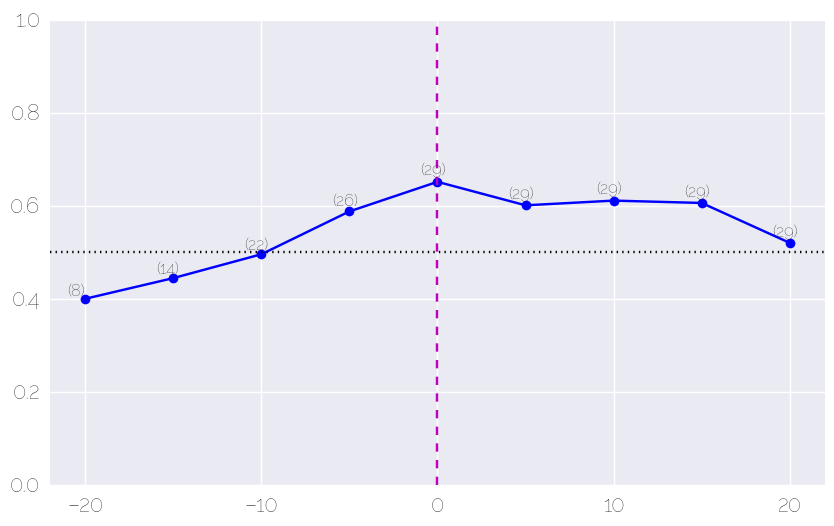

In [50]:
results = roc_results

font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelcolor'] = 'black'

plt.figure(dpi=1200,figsize=(10,6))
results = sorted(results,key= lambda x: x[0])

plt.plot(np.arange(-20.0,25.0,5.0),map(lambda x: x[3],results),'bo-')
plt.hold(True)

plt.xlim((-22.0, 22.0))
plt.ylim((0.0, 1.0))
plt.plot([-22.0,22.0],[0.5,0.5],color='k',linestyle=':')
plt.plot([0.0,0.0],[0.0,1.0],color='m',linestyle='--')
# plt.title('AUC as function of \nresection volume')
# plt.text(-15.0,0.1,title)

for ii in range(len(results)):
    if not np.isnan(results[ii][0]):
        plt.text(results[ii][0]-1.0,results[ii][3]*1.025,'(%i)'%results[ii][1].shape[0],
                 fontdict={'size':12,'weight':'normal'})

# plt.xlabel('Resection Dilation/Erosion (% of nodes)')
# plt.ylabel('AUC')
plt.grid(True)
# plt.show()
plt.savefig('../../fig/FigureS26A.png',bbox_inches='tight')